# Libraries

In [0]:
%pip install pingouin
%pip install squarify


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat
import plotly.express as px

import squarify

import pingouin as pg
import itertools

from PIL import Image

import squarify

import string

reference_date = pd.to_datetime("2023-08-01 00:00:00")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [0]:
#TABLE CREATED USING QUERY ON ORIGINAL DATABASE
#df_spark = spark.table("workspace.default.user_agg_tab")

#TABLE CREATED USING QUERY ON SESSION TABLE
df_spark = spark.table("workspace.default.usertab_from_sessiontab_spark") #TABLE SAVED AS "users_RawTab.csv"
df = df_spark.toPandas()
df = df.sort_values(by='user_id').reset_index(drop=True)

#replace age_bin coming from the delta table as dictionaries with actual pd.cut intervals
bins_range = [df.age_in_2023.min(), 20, 30, 40, 50, 60, 70, 80, 90]
df['age_bin'] = pd.cut(df.age_in_2023, bins=bins_range, right=False)

In [0]:
df_spark = spark.table("workspace.default.df_sessions_tab") #TABLE SAVED AS "sessions_preprocessed.csv"
df_sessions = df_spark.toPandas()

In [0]:
df.age_bin.value_counts()

age_bin
[40, 50)    2124
[30, 40)    1508
[50, 60)    1038
[20, 30)     697
[17, 20)     307
[60, 70)     225
[70, 80)      87
[80, 90)      12
Name: count, dtype: int64

In [0]:
df.columns

Index(['user_id', 'nr_sessions', 'date_last_booking_travelled',
       'page_clicks_tot', 'page_clicks_avg', 'flights_taken', 'hotels_stayed',
       'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'flight_taken_discount_nr', 'hotel_stayed_discount_avg',
       'hotel_stayed_discount_nr', 'hotel_and_flight_discount_nr',
       'flight_taken_price_avg', 'hotel_stayed_room_price_per_night_avg',
       'hotel_stayed_nights_avg', 'nr_airlines_taken', 'distance_km_tot',
       'distance_km_avg', 'duration_tot', 'duration_avg', 'birthdate',
       'gender', 'married', 'has_children', 'home_country', 'home_city',
       'home_airport', 'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'age_in_2023', 'age_bin', 'user_spend_tot', 'user_spend_avg',
       'booking_window_days_avg', 'booking_window_days_min',
       'booking_window_days_max', 'family_travelled_trip_nr',
       'non_family_tra

In [0]:
#RFM SEGMENTED DF LOADING
df_spark = spark.table("workspace.default.df_users_rfm") #TABLE SAVE AS "user_RFM.csv"
df_RFMsegm = df_spark.toPandas()
df_RFMsegm = df_RFMsegm.sort_values(by='user_id').reset_index(drop=True)

#ADDING RFM SEGMENTS COLUMNS TO df
df['R_score'] = df_RFMsegm['R_score']
df['F_score'] = df_RFMsegm['F_score']
df['M_score'] = df_RFMsegm['M_score']
df['RFM_score'] = df_RFMsegm['RFM_score']
df['RFM_label'] = df_RFMsegm['RFM_label']
df['RFM_label2'] = df_RFMsegm['RFM_label2']

df.columns

Index(['user_id', 'nr_sessions', 'date_last_booking_travelled',
       'page_clicks_tot', 'page_clicks_avg', 'flights_taken', 'hotels_stayed',
       'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'flight_taken_discount_nr', 'hotel_stayed_discount_avg',
       'hotel_stayed_discount_nr', 'hotel_and_flight_discount_nr',
       'flight_taken_price_avg', 'hotel_stayed_room_price_per_night_avg',
       'hotel_stayed_nights_avg', 'nr_airlines_taken', 'distance_km_tot',
       'distance_km_avg', 'duration_tot', 'duration_avg', 'birthdate',
       'gender', 'married', 'has_children', 'home_country', 'home_city',
       'home_airport', 'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'age_in_2023', 'age_bin', 'user_spend_tot', 'user_spend_avg',
       'booking_window_days_avg', 'booking_window_days_min',
       'booking_window_days_max', 'family_travelled_trip_nr',
       'non_family_tra

#Family_User

In [0]:
#how to define "family_user"?
df[(df.family_travelled_trip_nr > 0) & (3 * df.family_travelled_trip_nr >= df.non_family_travelled_trip_nr)]['RFM_label2'].value_counts()
# I will define "family_user" as that user with at least one family trip and non_family trips are maximum 3 times the number of family_travelled trips

RFM_label2
need attention          172
champion                156
dormant / one-timer      97
lost                     78
high potential           35
new / need attention     24
at risk                  13
loyal                     7
Name: count, dtype: int64

In [0]:
family_users = df[(df.family_travelled_trip_nr > 0) & (3 * df.family_travelled_trip_nr >= df.non_family_travelled_trip_nr)]['user_id']
family_users

2       101486
5       118043
21      189676
26      205044
55      316527
         ...  
5974    751545
5977    756434
5984    767426
5985    768291
5990    780167
Name: user_id, Length: 582, dtype: int64

In [0]:
df['family_user'] = df['user_id'].isin(family_users)

In [0]:
df[df.user_id.isin(family_users)]['family_user'].value_counts()

family_user
True    582
Name: count, dtype: int64

# Customized Functions

In [0]:
#function that calculate the effect size of a continuous variable with respect to a categorical variable
def effect_size_cont_disc(df, feat_cont, feat_discr):
    categor_list = list(df[feat_discr].value_counts().index)
    combin = list(itertools.combinations(categor_list, 2))
    print(f"--- {feat_cont} vs {feat_discr} ----------------")
    for x,y in combin:
        a = df.loc[df[feat_discr]==x, feat_cont]
        b = df.loc[df[feat_discr]==y, feat_cont]
        d = np.abs(pg.compute_effsize(a, b, eftype='cohen'))
        print(f"{x} vs {y}:  d={d} ({inter_eff(d)})")

#how to interpret effect size
def inter_eff(d):
    if d < 0.2:
        return "negligible"
    elif d < 0.5:
        return "small"
    elif d < 0.8:
        return "medium"
    else:
        return "large"

# Check & Adjustment

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 50 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   user_id                                5998 non-null   int64         
 1   nr_sessions                            5998 non-null   int64         
 2   date_last_booking_travelled            5434 non-null   datetime64[ns]
 3   page_clicks_tot                        5998 non-null   int64         
 4   page_clicks_avg                        5998 non-null   float64       
 5   flights_taken                          5998 non-null   int64         
 6   hotels_stayed                          5998 non-null   int64         
 7   nr_booked_and_travelled                5998 non-null   int64         
 8   nr_booked_but_cancelled                5998 non-null   int64         
 9   nr_cancellation_session                5998 non-null   int64   

In [0]:
#converting date from objects to date format
#NO NEED FOR THIS COLUMN IF USERTAB FROM SESSIONTAB IS USED

#df['birthdate'] = pd.to_datetime(df['birthdate'])
#df['sign_up_date'] = pd.to_datetime(df['sign_up_date'])

In [0]:
#creating age column
#NO NEED FOR THIS COLUMN IF USERTAB FROM SESSIONTAB IS USED

#df['age_in_2023'] = 2025 - df['birthdate'].dt.year

In [0]:
df.describe()

,user_id,nr_sessions,date_last_booking_travelled,page_clicks_tot,page_clicks_avg,flights_taken,hotels_stayed,nr_booked_and_travelled,nr_booked_but_cancelled,nr_cancellation_session,nr_no_booking,flight_taken_discount_avg,flight_taken_discount_nr,hotel_stayed_discount_avg,hotel_stayed_discount_nr,hotel_and_flight_discount_nr,flight_taken_price_avg,hotel_stayed_room_price_per_night_avg,hotel_stayed_nights_avg,nr_airlines_taken,distance_km_tot,distance_km_avg,duration_tot,duration_avg,birthdate,home_airport_lat,home_airport_lon,sign_up_date,age_in_2023,user_spend_tot,user_spend_avg,booking_window_days_avg,booking_window_days_min,booking_window_days_max,family_travelled_trip_nr,non_family_travelled_trip_nr,R_score,F_score,M_score,RFM_score
count,5998.000000,5998.000000,5434,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,1946.000000,5998.000000,1799.000000,5998.000000,5998.000000,5032.000000,5324.000000,5324.000000,5998.000000,5032.000000,5032.000000,5433.000000,5433.000000,5998,5998.000000,5998.000000,5998,5998.000000,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,5998.000000,5998.000000,5434.000000,5998.000000,5434.000000,5434.000000
mean,545440.695565,8.181561,2023-05-07 22:36:19.841737216,143.422808,17.528903,4.252751,2.296265,2.561854,0.099867,0.099867,5.419973,0.141196,0.381627,0.110689,0.354618,0.063021,464.459221,178.384264,4.366794,1.985328,5559.125553,2183.494960,13.079698,4.776718,1982-03-13 01:45:09.303100992,38.439744,-94.176286,2023-01-20 02:26:12.524174592,41.306936,3387.539549,1228.762106,11.878054,7.440845,18.903836,0.128376,2.433478,3.007729,2.621207,3.000000,8.797203
min,23557.000000,5.000000,2023-01-04 00:52:00,33.000000,4.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.050000,0.000000,0.000000,5.350000,21.000000,1.000000,0.000000,27.440590,27.440590,0.000000,0.000000,1935-05-10 00:00:00,21.316000,-157.927000,2021-07-22 00:00:00,17.000000,9.270000,9.270000,1.502164,0.405613,1.502164,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000
25%,517152.000000,8.000000,2023-03-25 19:04:00,101.000000,12.444444,2.000000,1.000000,1.000000,0.000000,0.000000,4.000000,0.100000,0.000000,0.050000,0.000000,0.000000,276.923750,124.000000,2.666667,1.000000,2869.757127,1466.781117,7.000000,3.000000,1974-09-26 06:00:00,33.818000,-112.383000,2023-01-08 00:00:00,34.000000,1572.950000,703.460000,6.474713,4.604832,7.687784,0.000000,1.000000,2.000000,1.000000,2.000000,6.000000
50%,540542.000000,8.000000,2023-05-15 19:02:30,127.000000,15.555556,4.000000,2.000000,3.000000,0.000000,0.000000,5.000000,0.100000,0.000000,0.100000,0.000000,0.000000,386.713750,163.000000,3.666667,2.000000,4833.117616,2018.597870,12.000000,4.000000,1981-10-20 12:00:00,39.103000,-90.035000,2023-01-19 00:00:00,42.000000,2728.530000,991.374333,7.584252,5.651169,9.436522,0.000000,2.000000,3.000000,3.000000,3.000000,9.000000
75%,574146.000000,8.000000,2023-06-25 11:08:00,160.000000,19.625000,6.000000,3.000000,4.000000,0.000000,0.000000,7.000000,0.200000,1.000000,0.150000,1.000000,0.000000,538.844500,212.500000,5.333333,3.000000,7468.559065,2666.580704,18.000000,5.666667,1989-04-07 18:00:00,42.266500,-79.370000,2023-02-05 00:00:00,49.000000,4480.707500,1422.930000,8.835836,6.865475,11.607685,0.000000,3.000000,4.000000,4.000000,4.000000,11.000000
max,844489.000000,12.000000,2023-07-20 22:03:00,873.000000,109.125000,16.000000,8.000000,8.000000,2.000000,2.000000,12.000000,0.500000,4.000000,0.450000,4.000000,2.000000,9135.130000,1063.000000,30.000000,7.000000,29678.028930,15813.862545,67.000000,30.000000,2006-12-28 00:00:00,61.251000,-63.499000,2023-05-18 00:00:00,88.000000,28261.430000,14130.715000,364.935856,364.935856,365.203032,4.000000,8.000000,5.000000,5.000000,5.000000,15.000000
std,64924.749760,0.488193,NaN,71.693695,8.670006,2.970558,1.447804,1.524441,0.306448,0.306448,1.611049,0.081572,0.601462,0.056868,0.593546,0.249788,442.248573,85.013701,2.743511,1.351554,3688.77313

#EDA

##Histograms

In [0]:
df.dtypes

user_id                                           int64
nr_sessions                                       int64
date_last_booking_travelled              datetime64[ns]
page_clicks_tot                                   int64
page_clicks_avg                                 float64
flights_taken                                     int64
hotels_stayed                                     int64
nr_booked_and_travelled                           int64
nr_booked_but_cancelled                           int64
nr_cancellation_session                           int64
nr_no_booking                                     int64
flight_taken_discount_avg                       float64
flight_taken_discount_nr                          int64
hotel_stayed_discount_avg                       float64
hotel_stayed_discount_nr                          int64
hotel_and_flight_discount_nr                      int64
flight_taken_price_avg                          float64
hotel_stayed_room_price_per_night_avg           

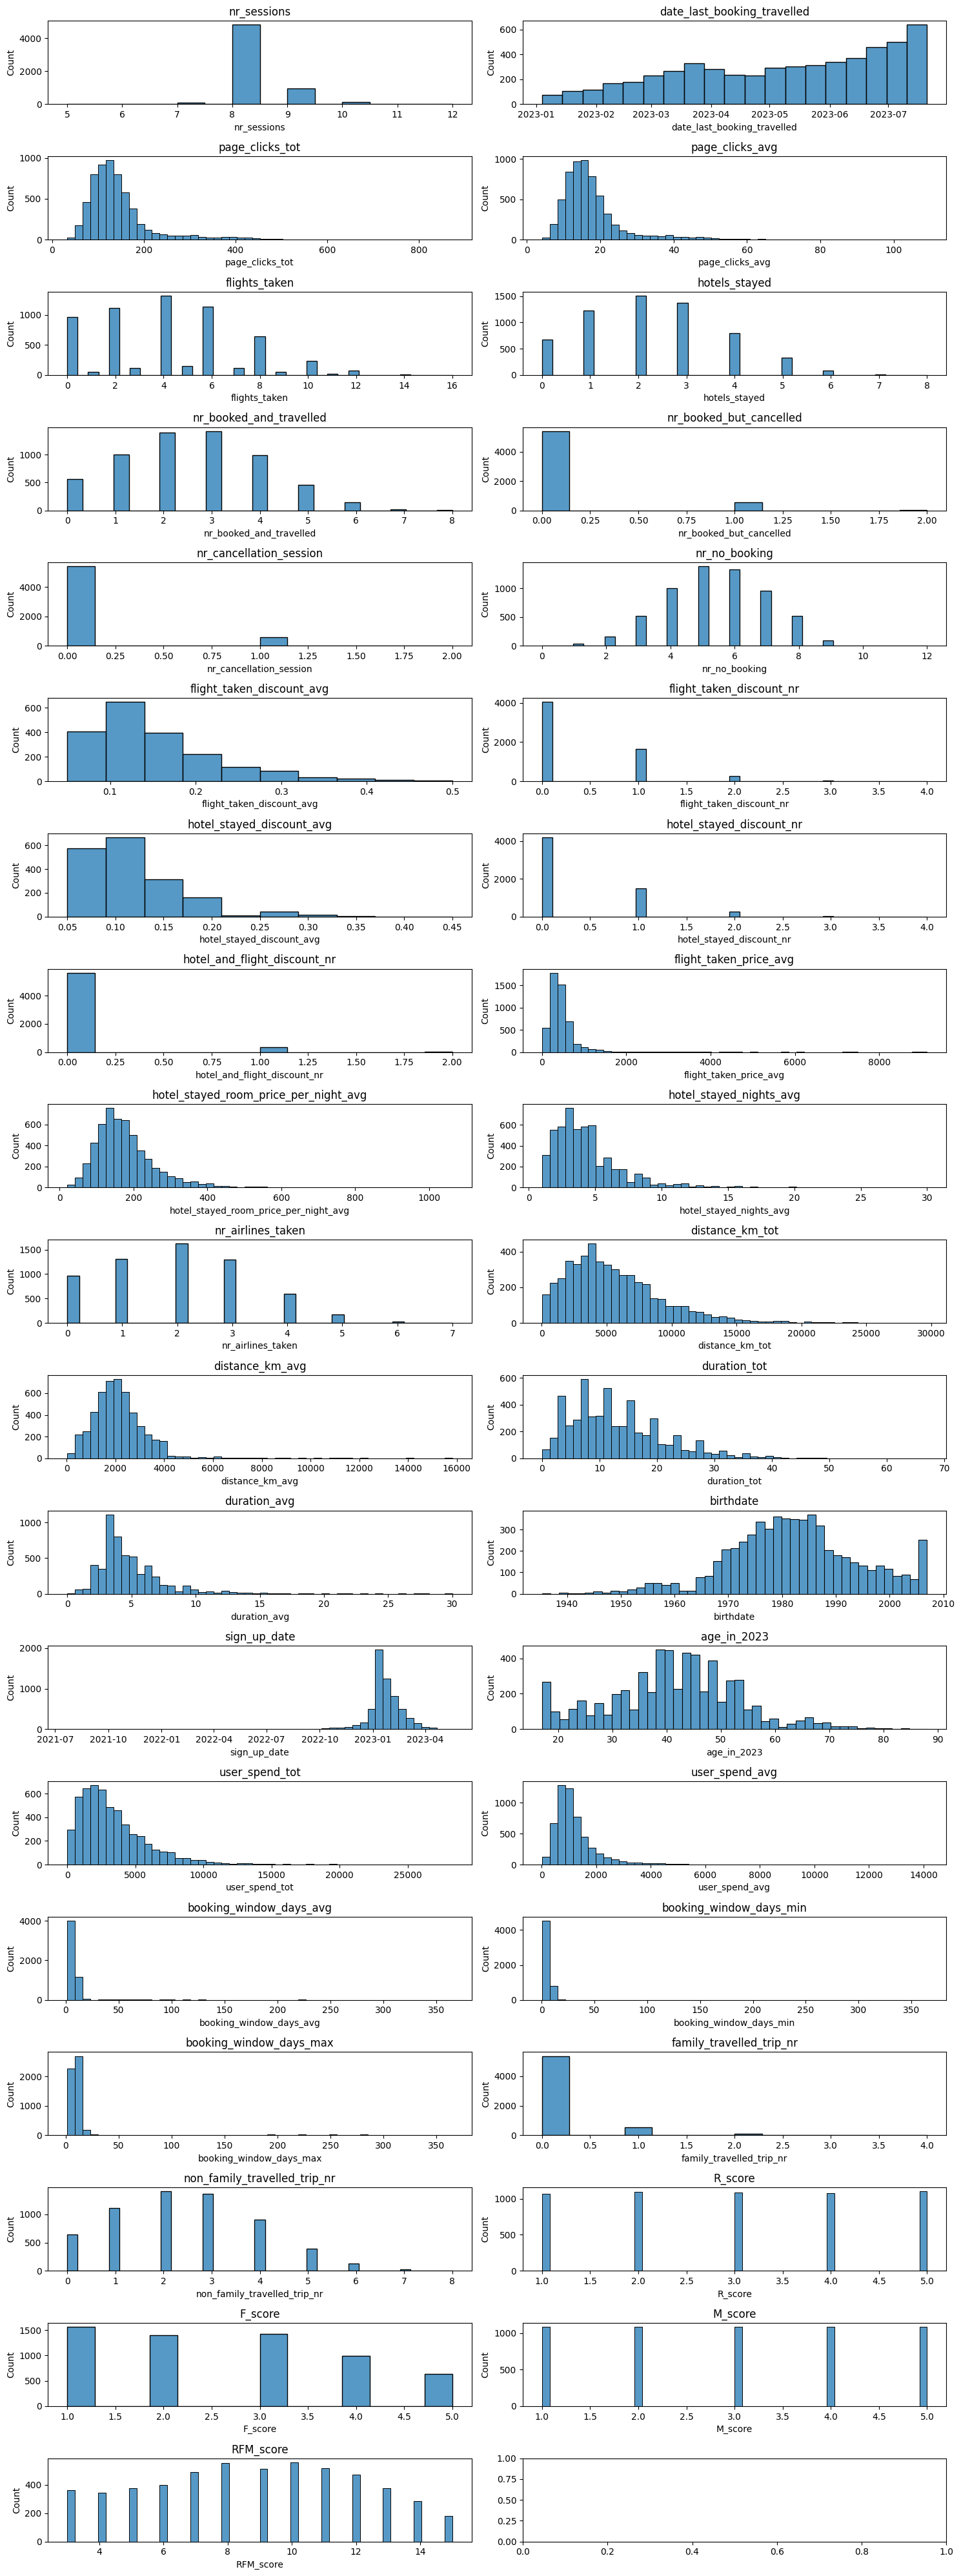

In [0]:
#create a list of numeric and datetime columns name, excluding "user_id"
list_feat = [col for col in df.select_dtypes(include=['number', 'datetime64[ns]']).columns if col not in ['user_id', 'home_airport_lat', 'home_airport_lon']]

n_plots = len(list_feat)
n_cols = 2

fig, axes = plt.subplots(nrows=int(np.ceil(n_plots/n_cols)), ncols=n_cols, figsize=(15,40))
for i, ax in zip(list_feat, axes.flatten()):

    if i in ['flight_taken_discount_avg','hotel_stayed_discount_avg']:
        sns.histplot(df[i],bins=10, ax=ax)
    elif df[i].dtype=='float64' or i in ['page_clicks_tot','sign_up_date']:
        sns.histplot(df[i],bins=50, ax=ax)
    else:
        sns.histplot(df[i], ax=ax)
    ax.set_title(i)
plt.tight_layout()
plt.show()

##Barplot

In [0]:
df.dtypes

user_id                                           int64
nr_sessions                                       int64
date_last_booking_travelled              datetime64[ns]
page_clicks_tot                                   int64
page_clicks_avg                                 float64
flights_taken                                     int64
hotels_stayed                                     int64
nr_booked_and_travelled                           int64
nr_booked_but_cancelled                           int64
nr_cancellation_session                           int64
nr_no_booking                                     int64
flight_taken_discount_avg                       float64
flight_taken_discount_nr                          int64
hotel_stayed_discount_avg                       float64
hotel_stayed_discount_nr                          int64
hotel_and_flight_discount_nr                      int64
flight_taken_price_avg                          float64
hotel_stayed_room_price_per_night_avg           

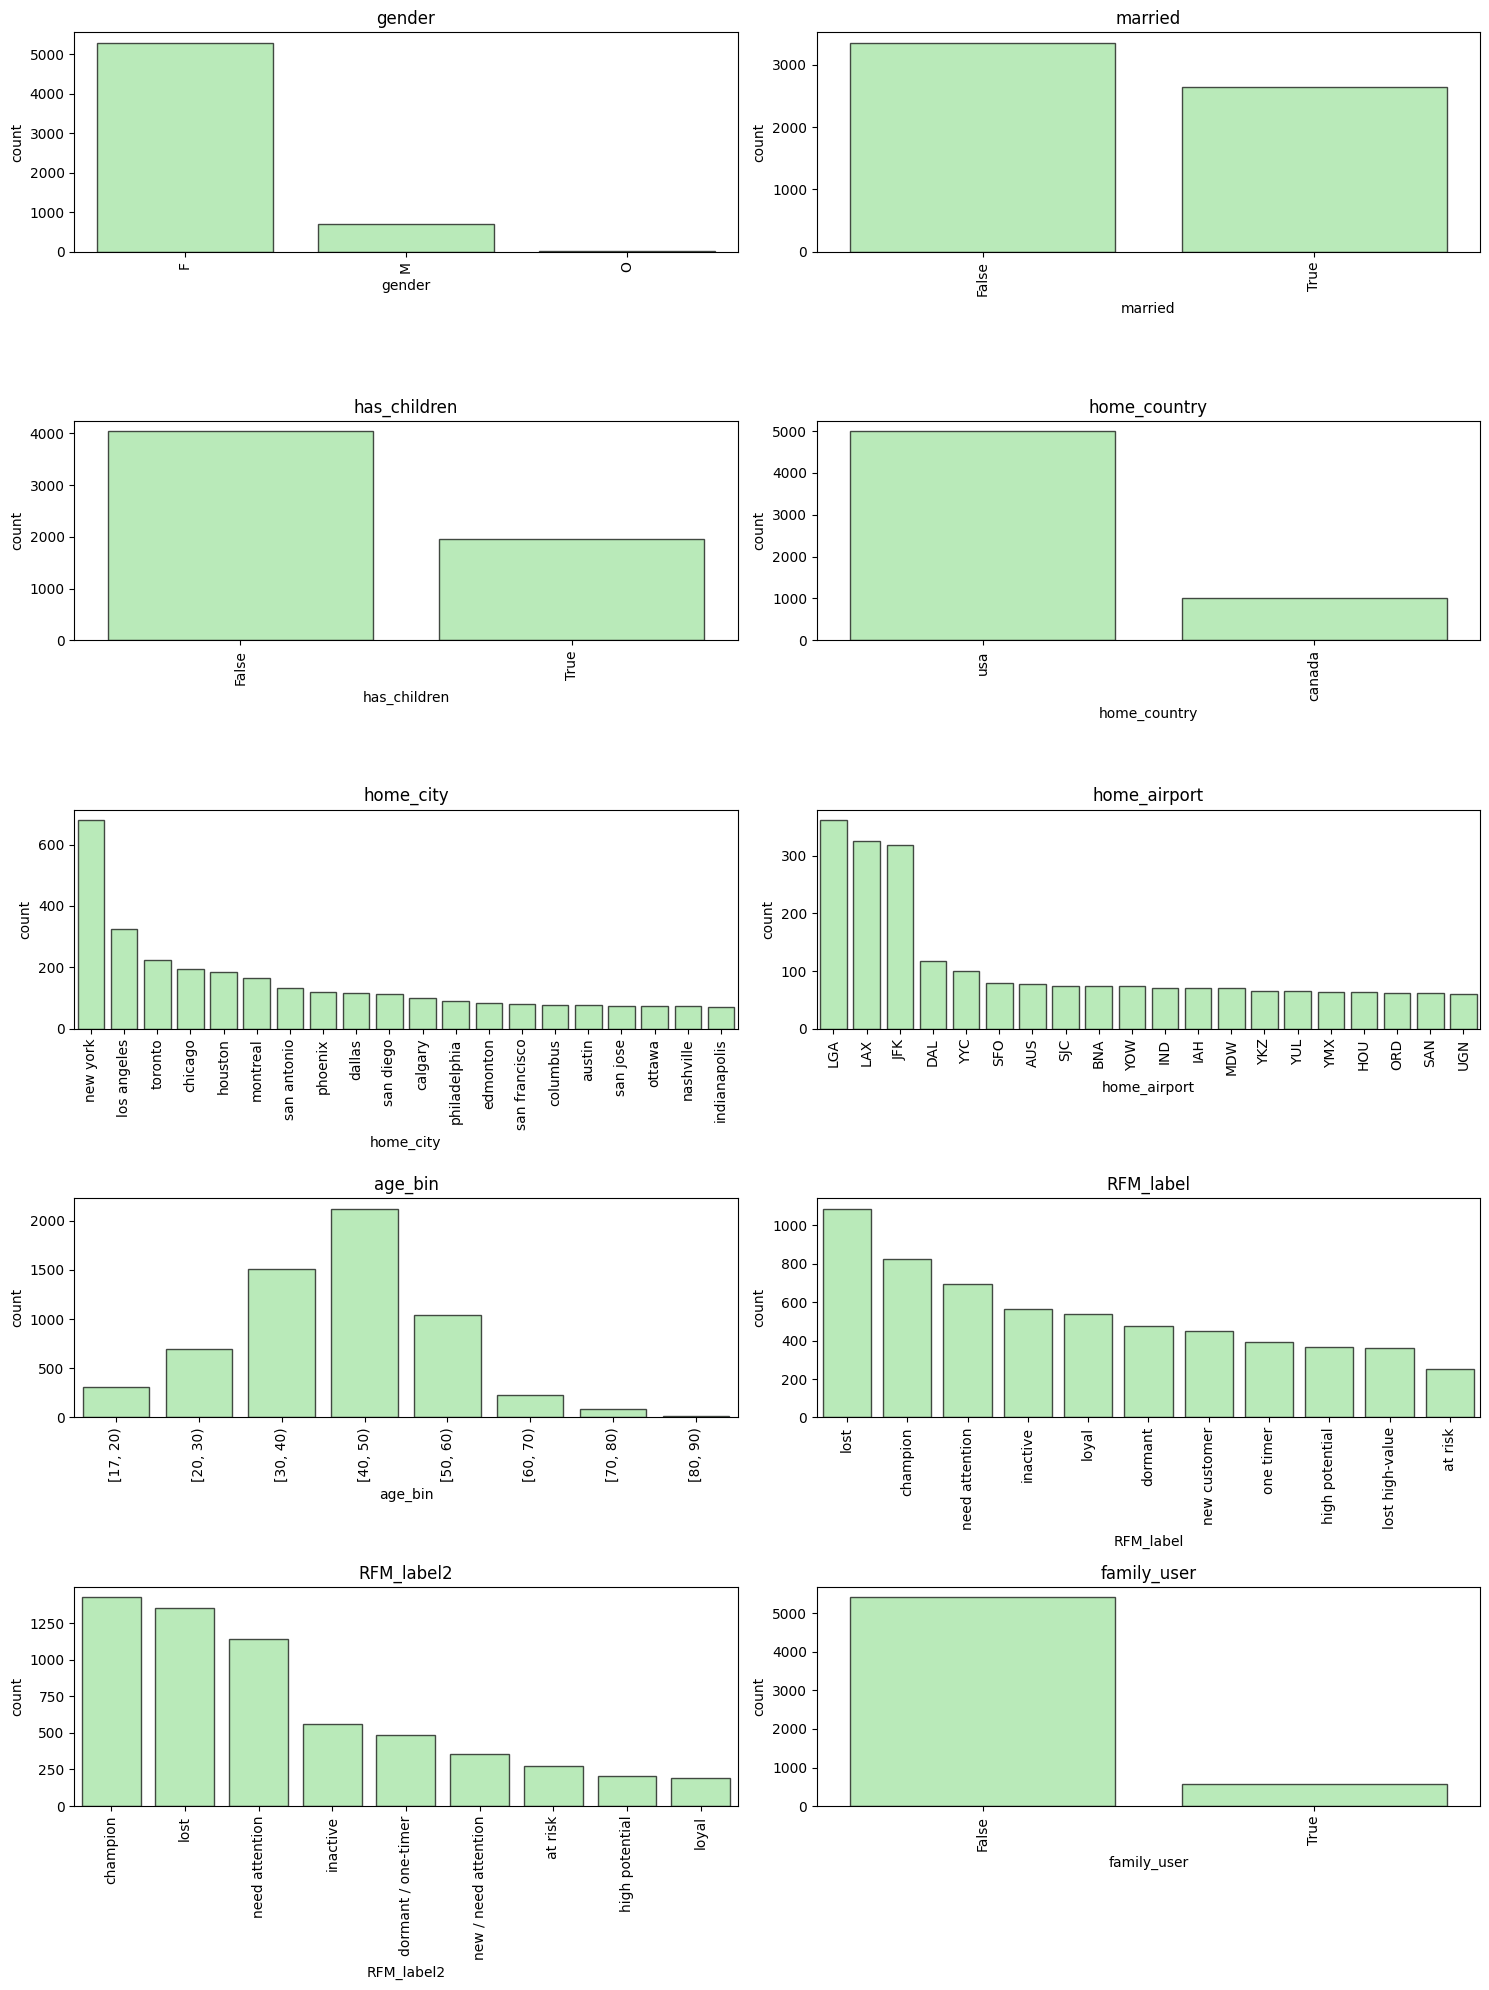

In [0]:
#create a list of numeric and datetime columns name, excluding "user_id"
list_feat = [col for col in df.select_dtypes(exclude=['number', 'datetime64[ns]']).columns]# if col not in ['user_id', 'home_airport_lat', 'home_airport_lon']]

n_plots = len(list_feat)
n_cols = 2

fig, axes = plt.subplots(nrows=int(np.ceil(n_plots/n_cols)), ncols=n_cols, figsize=(15,20))
for i, ax in zip(list_feat, axes.flatten()):
    sns.barplot(data=df[[i]].value_counts().head(20).reset_index(), x=i, y='count', ax=ax, alpha=0.7, edgecolor='black', color='lightgreen')
    ax.set_title(i)
    plt.setp(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

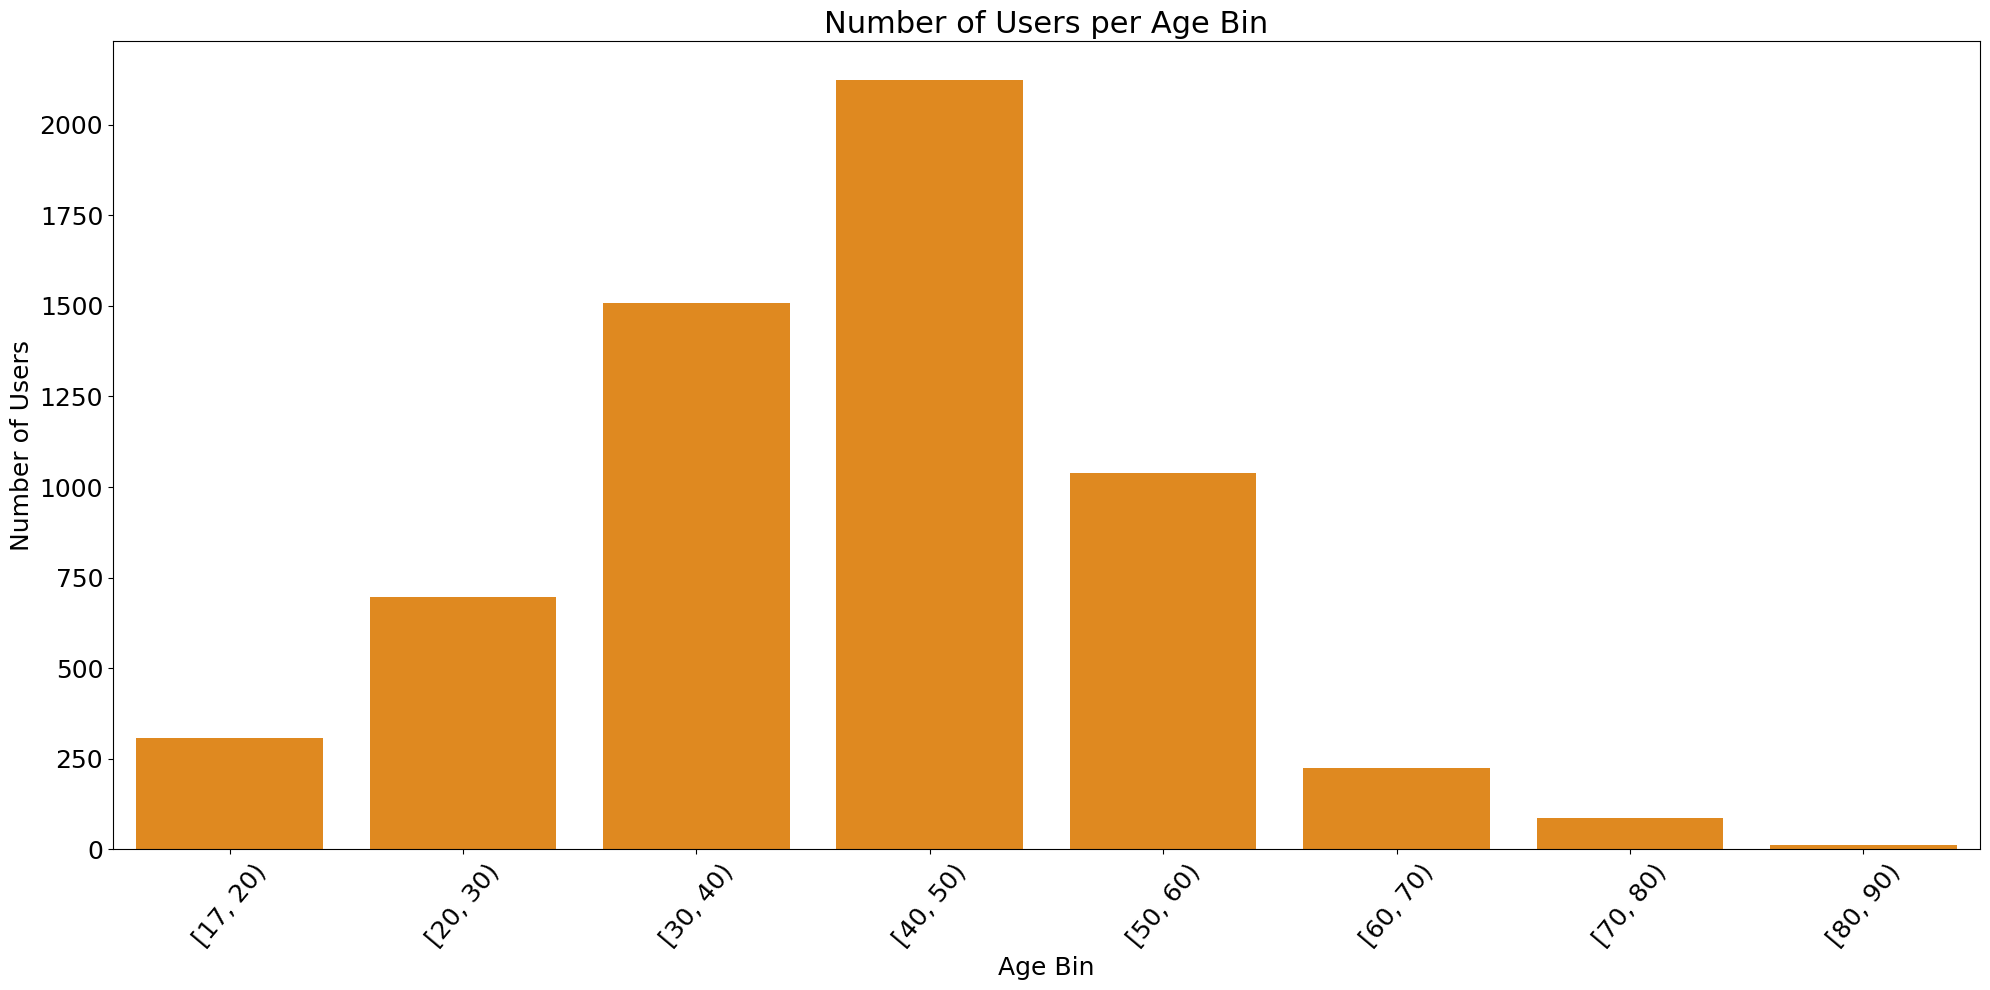

In [0]:
age_bin_counts = df['age_bin'].value_counts(sort=False)
plt.figure(figsize=(20,10))
sns.barplot(x=age_bin_counts.index.astype(str), y=age_bin_counts.values, color='#FF8C00')  # arancio scuro pastello
plt.xlabel('Age Bin', fontsize=18)
plt.ylabel('Number of Users', fontsize=18)
plt.title('Number of Users per Age Bin', fontsize=22)
plt.xticks(rotation=50, fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

In [0]:
df.columns

Index(['user_id', 'nr_sessions', 'date_last_booking_travelled',
       'page_clicks_tot', 'page_clicks_avg', 'flights_taken', 'hotels_stayed',
       'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'flight_taken_discount_nr', 'hotel_stayed_discount_avg',
       'hotel_stayed_discount_nr', 'hotel_and_flight_discount_nr',
       'flight_taken_price_avg', 'hotel_stayed_room_price_per_night_avg',
       'hotel_stayed_nights_avg', 'nr_airlines_taken', 'distance_km_tot',
       'distance_km_avg', 'duration_tot', 'duration_avg', 'birthdate',
       'gender', 'married', 'has_children', 'home_country', 'home_city',
       'home_airport', 'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'age_in_2023', 'age_bin', 'user_spend_tot', 'user_spend_avg',
       'booking_window_days_avg', 'booking_window_days_min',
       'booking_window_days_max', 'family_travelled_trip_nr',
       'non_family_tra

## HeatMap

<Axes: >

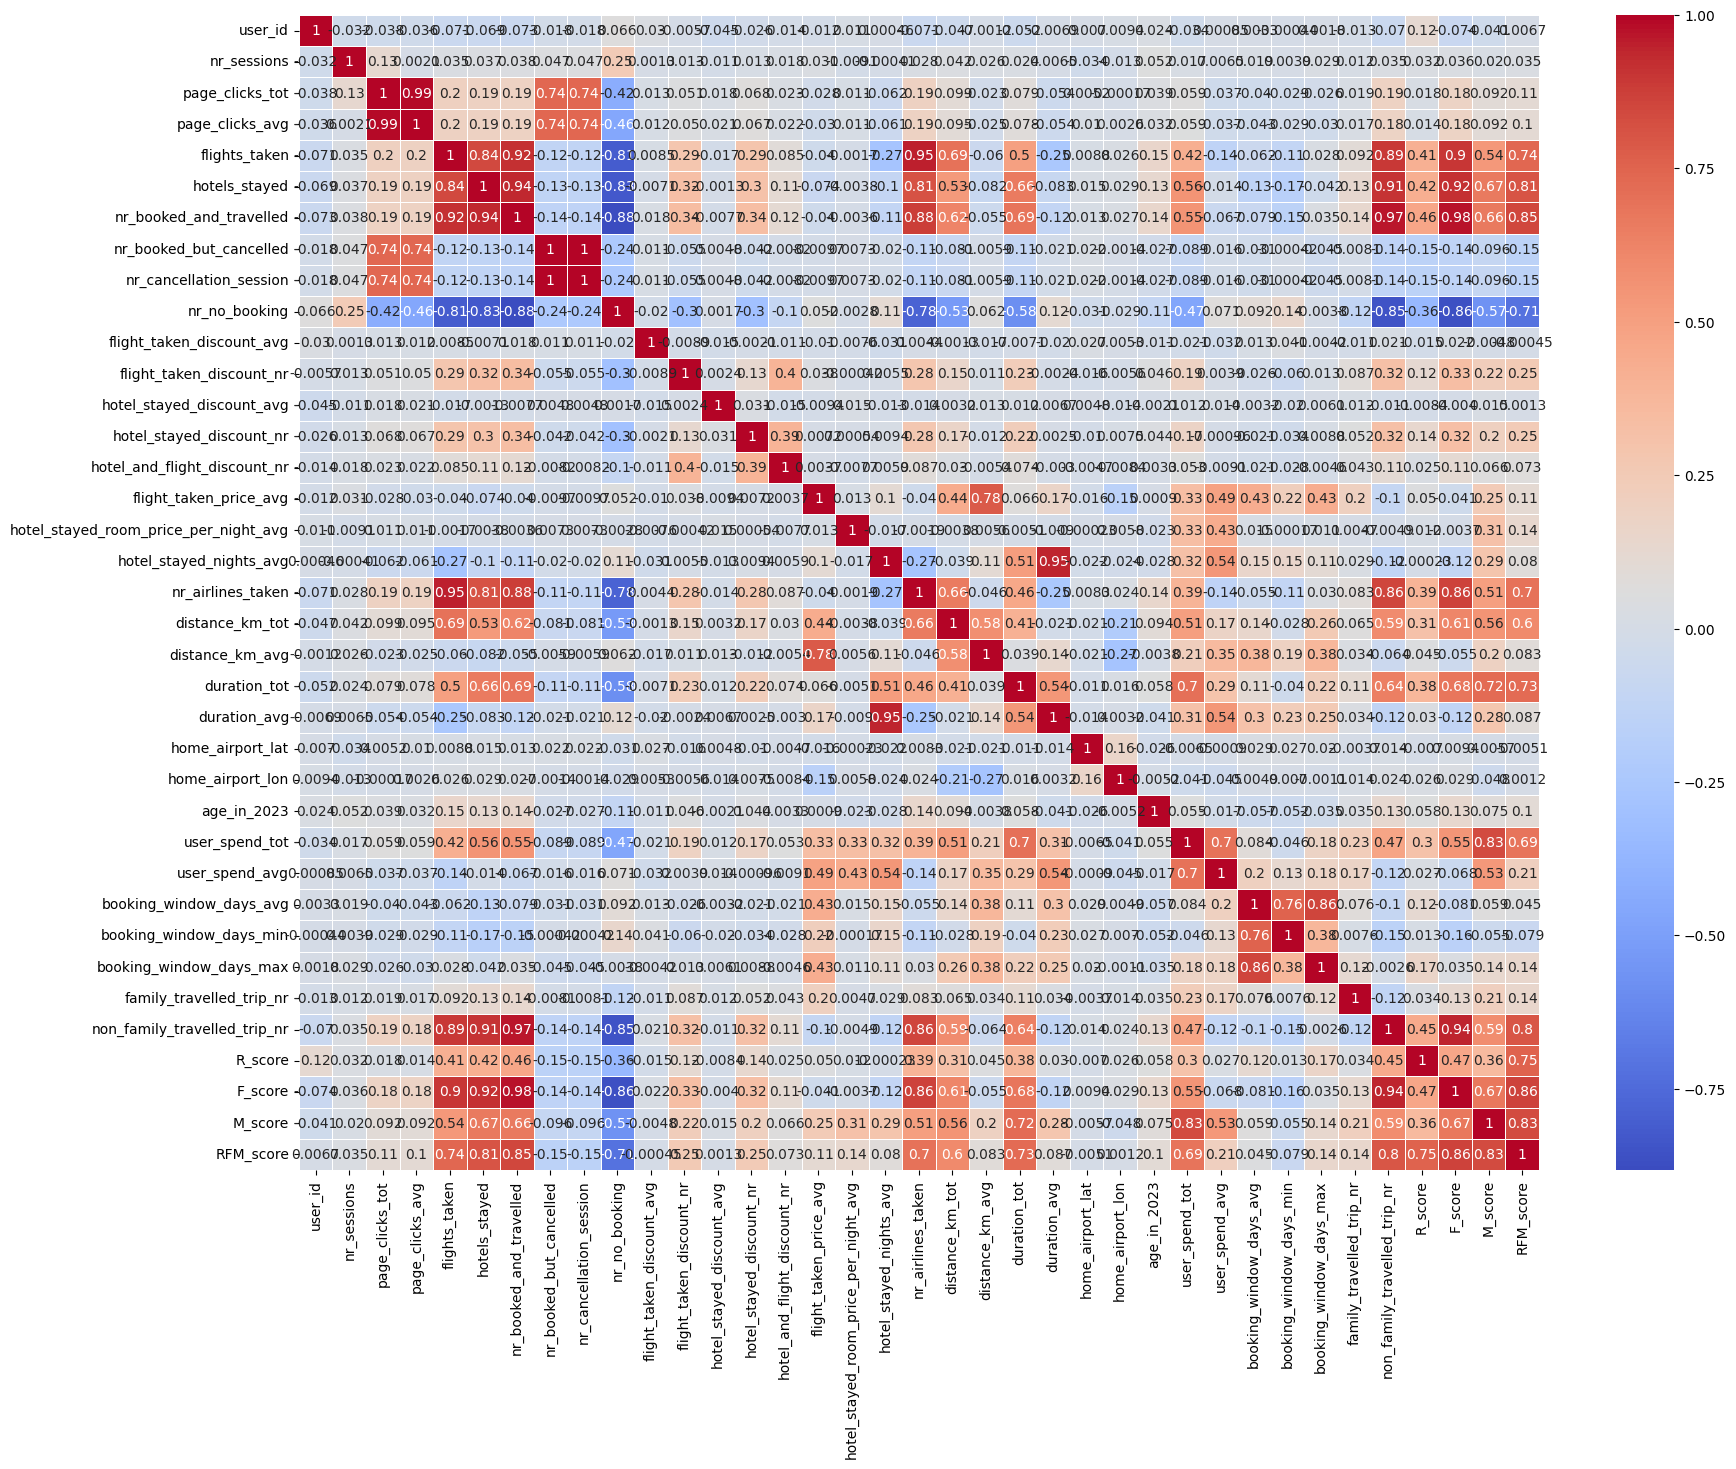

In [0]:
numerical_data = df.select_dtypes(include=['number'])  
correlation_matrix = numerical_data.corr(method='pearson')  
plt.figure(figsize=(20, 15))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

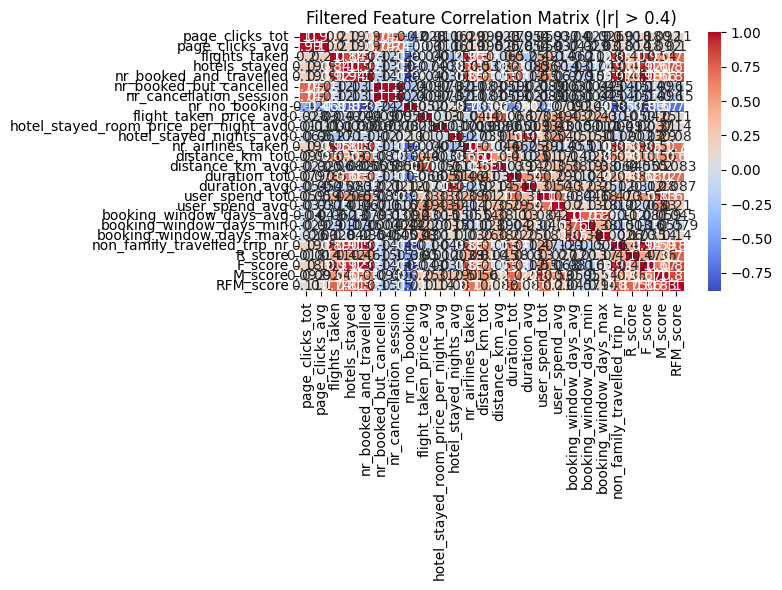

In [0]:
corr_limit = 0.4

# Identify features with at least one absolute correlation > 0.4 (excluding diagonal)
mask = np.eye(correlation_matrix.shape[0], dtype=bool)  #identity matrix with True on diagonal
corr_no_diag = correlation_matrix.mask(mask)    #mask the diagonal, i.e. replace diagonal values with NaN
features_to_plot = corr_no_diag.columns[(corr_no_diag.abs() > corr_limit).any()]

# Filter the correlation matrix
filtered_corr = correlation_matrix.loc[features_to_plot, features_to_plot]

plt.figure(figsize=(8, 6))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f"Filtered Feature Correlation Matrix (|r| > {corr_limit})")
plt.tight_layout()
plt.show()

* page_clicks (avg) - nr_cancellation: r=0.74
* page_clicks (avg) - nr_trip: r=0.47
---
* flight_taken - hotel_stayed: r=0.84
* flight_taken - nr_trip: r=0.95
* flight_taken - nr_airlines_taken: r=0.95
---
* hotel_stayed - nr_trip: r=0.91
* hotel_stayed - nr_airlines_taken: r=0.8
---
* nr_trip - nr_airlines_taken: r=0.86
---

Note that nr_trip include also those 

In [0]:
# trip_id issue: check it from sessions dataframe----------------------------------
print(f"Percentage of sessions w/o trip_id: {round(df_sessions.trip_id.isnull().sum()/df_sessions.shape[0] * 100, 2)}%")
print(f"Percentage of cancelled sessions: {round(df_sessions.cancellation.value_counts()[True]/df_sessions.shape[0] * 100, 2)}%")
print(f"Percentage of cancelled sessions w/o trip_id: {round(df_sessions.loc[(df_sessions.trip_id.isnull())&(df_sessions.cancellation == True)].shape[0]/df_sessions.shape[0] * 100, 2)}%")

Percentage of sessions w/o trip_id: 66.25%
Percentage of cancelled sessions: 1.22%
Percentage of cancelled sessions w/o trip_id: 0.0%


as can be seen, 66.6% of sessions have no "trip_id", and none of these has been cancelled

In [0]:
df_sessions.columns

Index(['session_id', 'user_id', 'trip_id', 'session_start', 'session_end',
       'page_clicks', 'flight_discount', 'flight_discount_amount',
       'hotel_discount', 'hotel_discount_amount', 'flight_booked',
       'hotel_booked', 'cancellation', 'birthdate', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'origin_airport', 'destination', 'destination_airport', 'seats',
       'return_flight_booked', 'departure_time', 'return_time', 'checked_bags',
       'trip_airline', 'destination_airport_lat', 'destination_airport_lon',
       'base_fare_usd', 'hotel_name', 'nights_calc', 'rooms', 'check_in_time',
       'check_out_time', 'hotel_price_per_room_night_usd', 'age_in_2023',
       'session_duration_min', 'days_between_flights', 'age_bin', 'status',
       'distance_km', 'duration', 'session_cost', 'booking_window_days',
       'family_session'],
      dtype='object')

## Bivariate Analysis

### Some trends by age

In [0]:
df.columns

Index(['user_id', 'nr_sessions', 'date_last_booking_travelled',
       'page_clicks_tot', 'page_clicks_avg', 'flights_taken', 'hotels_stayed',
       'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'flight_taken_discount_nr', 'hotel_stayed_discount_avg',
       'hotel_stayed_discount_nr', 'hotel_and_flight_discount_nr',
       'flight_taken_price_avg', 'hotel_stayed_room_price_per_night_avg',
       'hotel_stayed_nights_avg', 'nr_airlines_taken', 'distance_km_tot',
       'distance_km_avg', 'duration_tot', 'duration_avg', 'birthdate',
       'gender', 'married', 'has_children', 'home_country', 'home_city',
       'home_airport', 'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'age_in_2023', 'age_bin', 'user_spend_tot', 'user_spend_avg',
       'booking_window_days_avg', 'booking_window_days_min',
       'booking_window_days_max', 'family_travelled_trip_nr',
       'non_family_tra

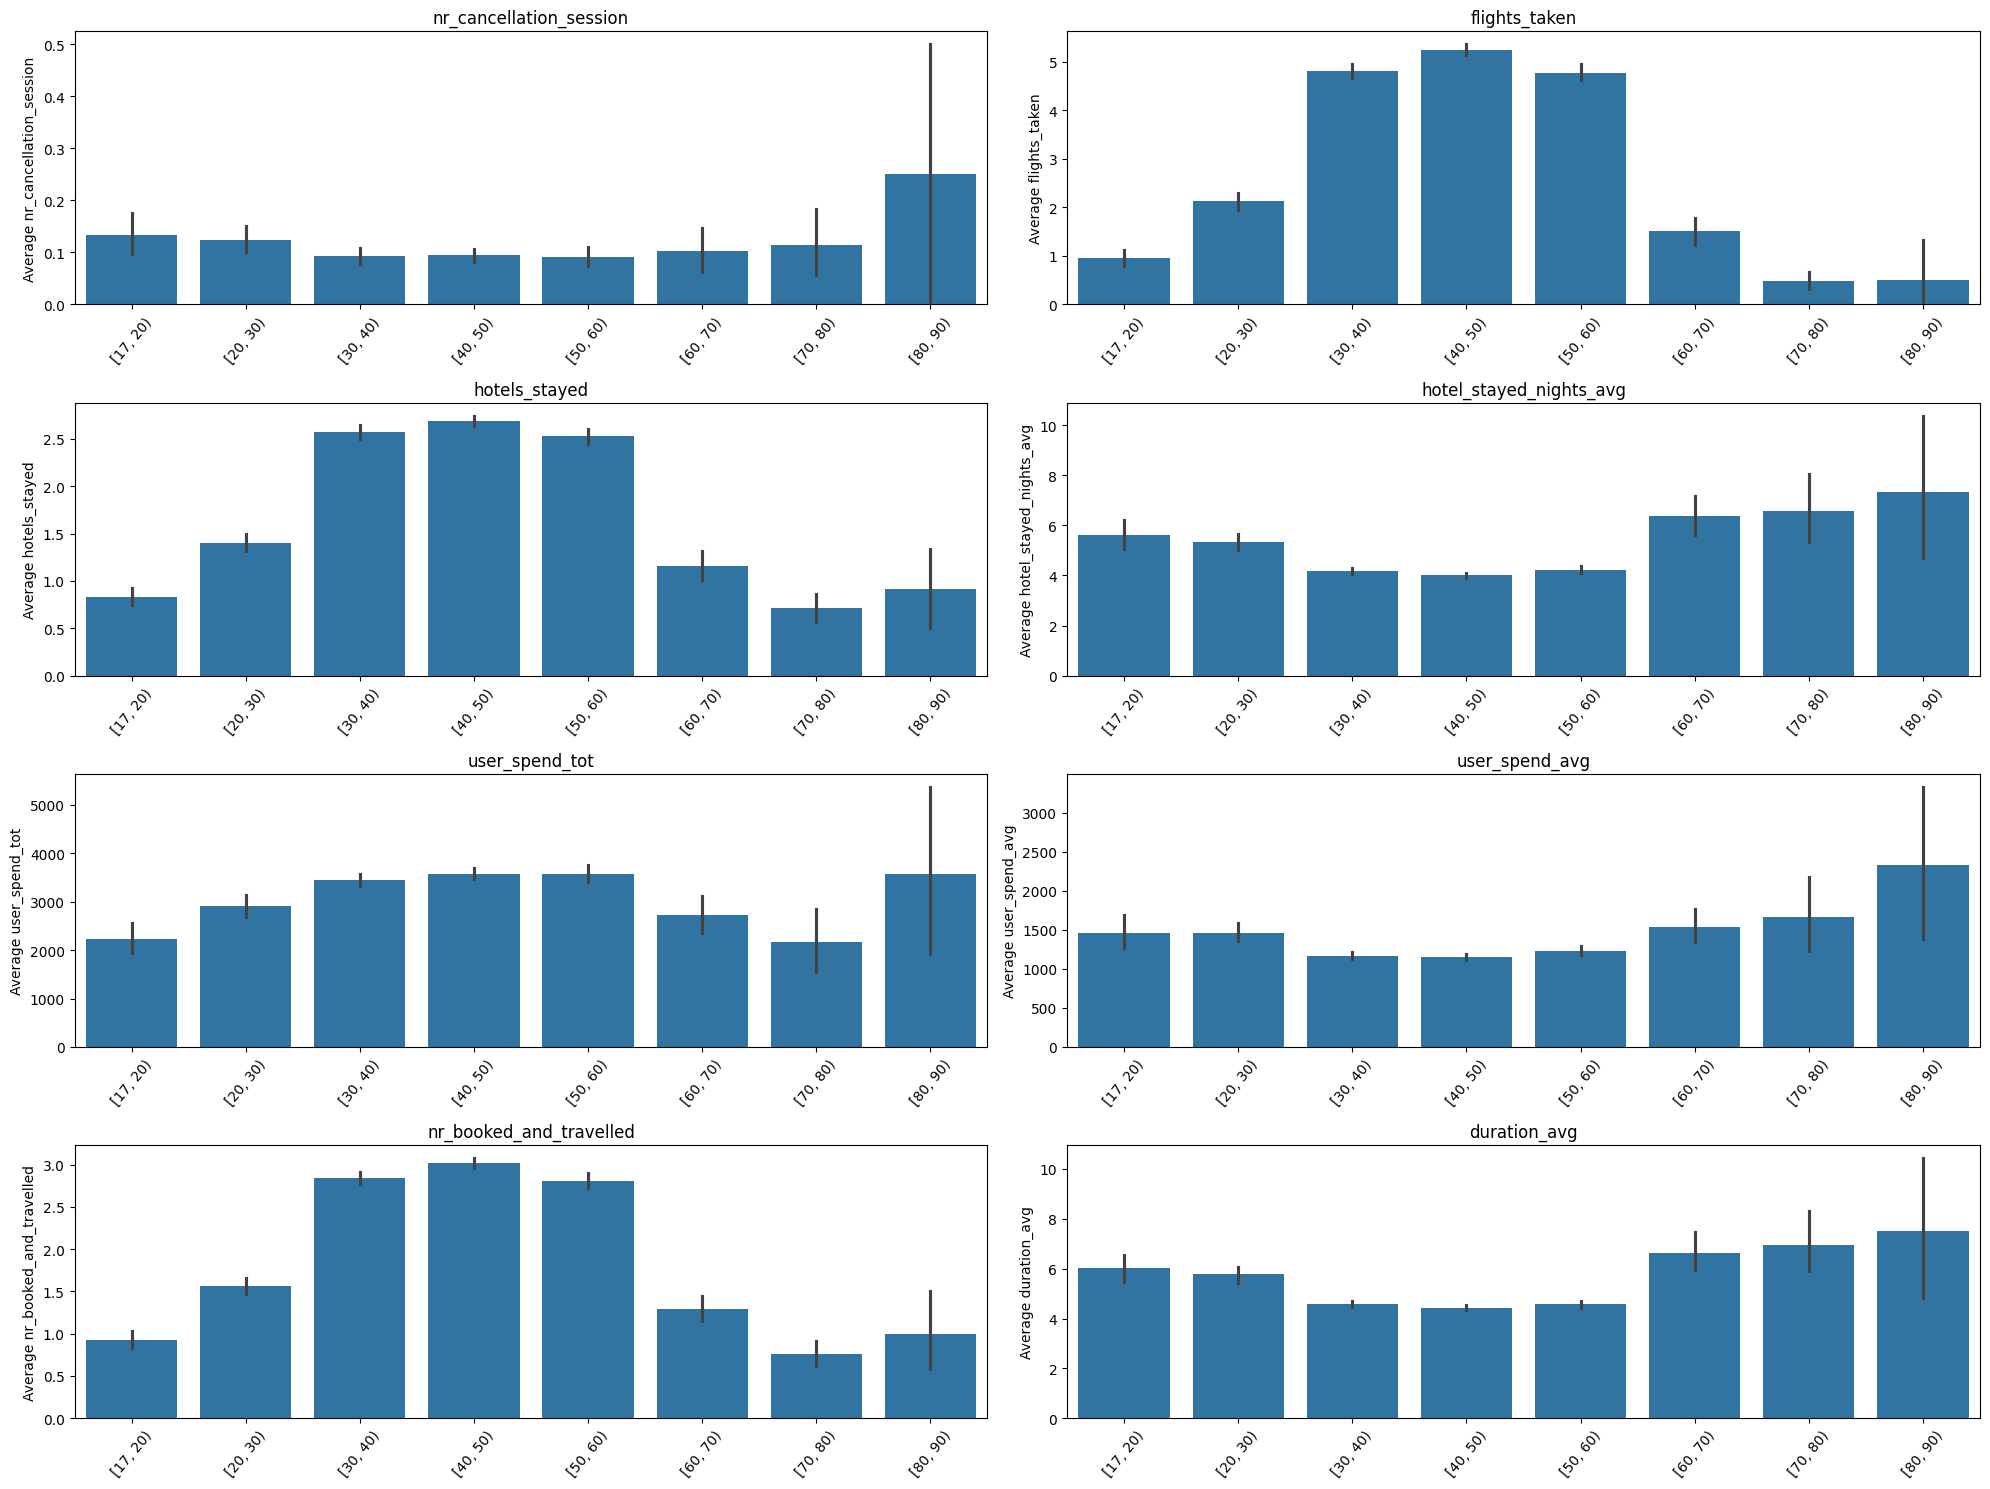

In [0]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,15))
numerical_cols = ['nr_cancellation_session', 'flights_taken', 'hotels_stayed', 'hotel_stayed_nights_avg', 'user_spend_tot', 'user_spend_avg', 'nr_booked_and_travelled','duration_avg']

for i, ax in zip(numerical_cols, axes.flatten()):
    sns.barplot(data=df, x='age_bin', y=i, ax=ax, estimator=np.mean) #right=False means that it includes the low limit value in the bin
    plt.setp(ax.get_xticklabels(), rotation=50)
    ax.set_xlabel("")
    ax.set_ylabel(f"Average {i}")
    ax.set_title(i)
plt.tight_layout()
plt.show()

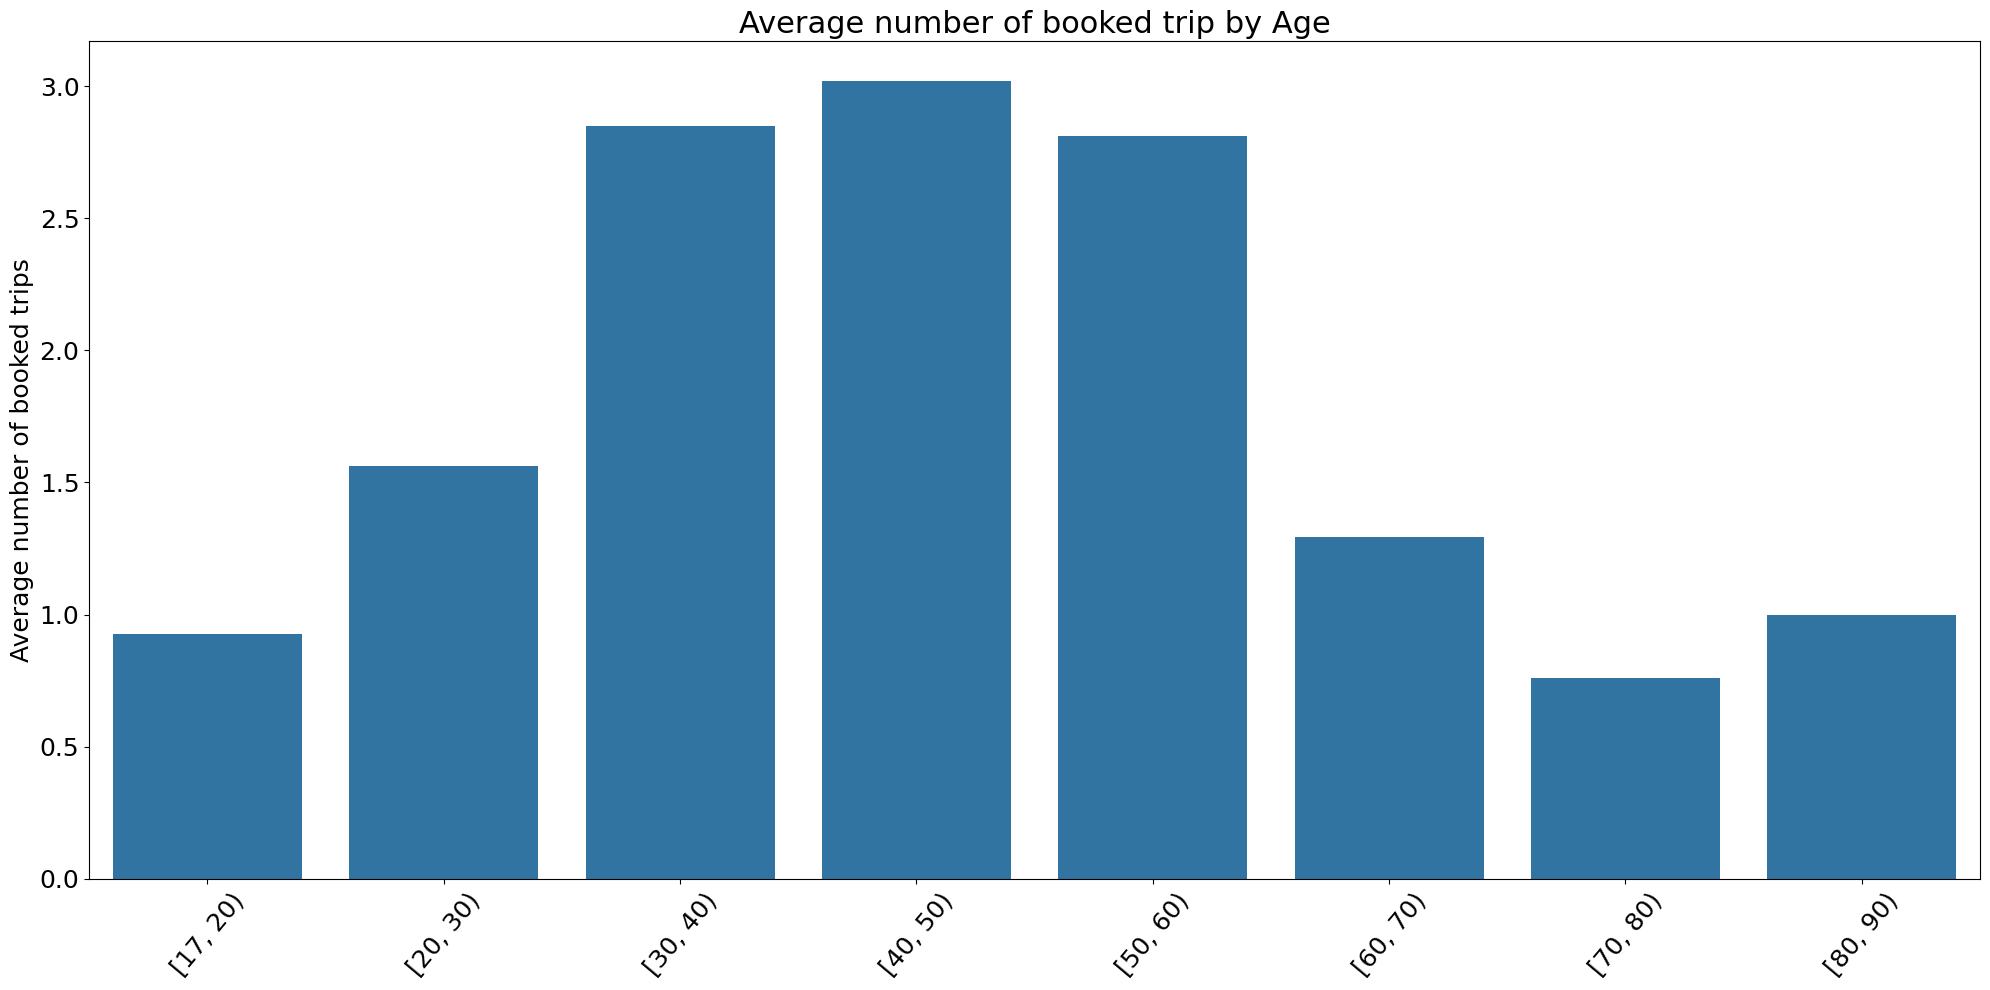

ciao


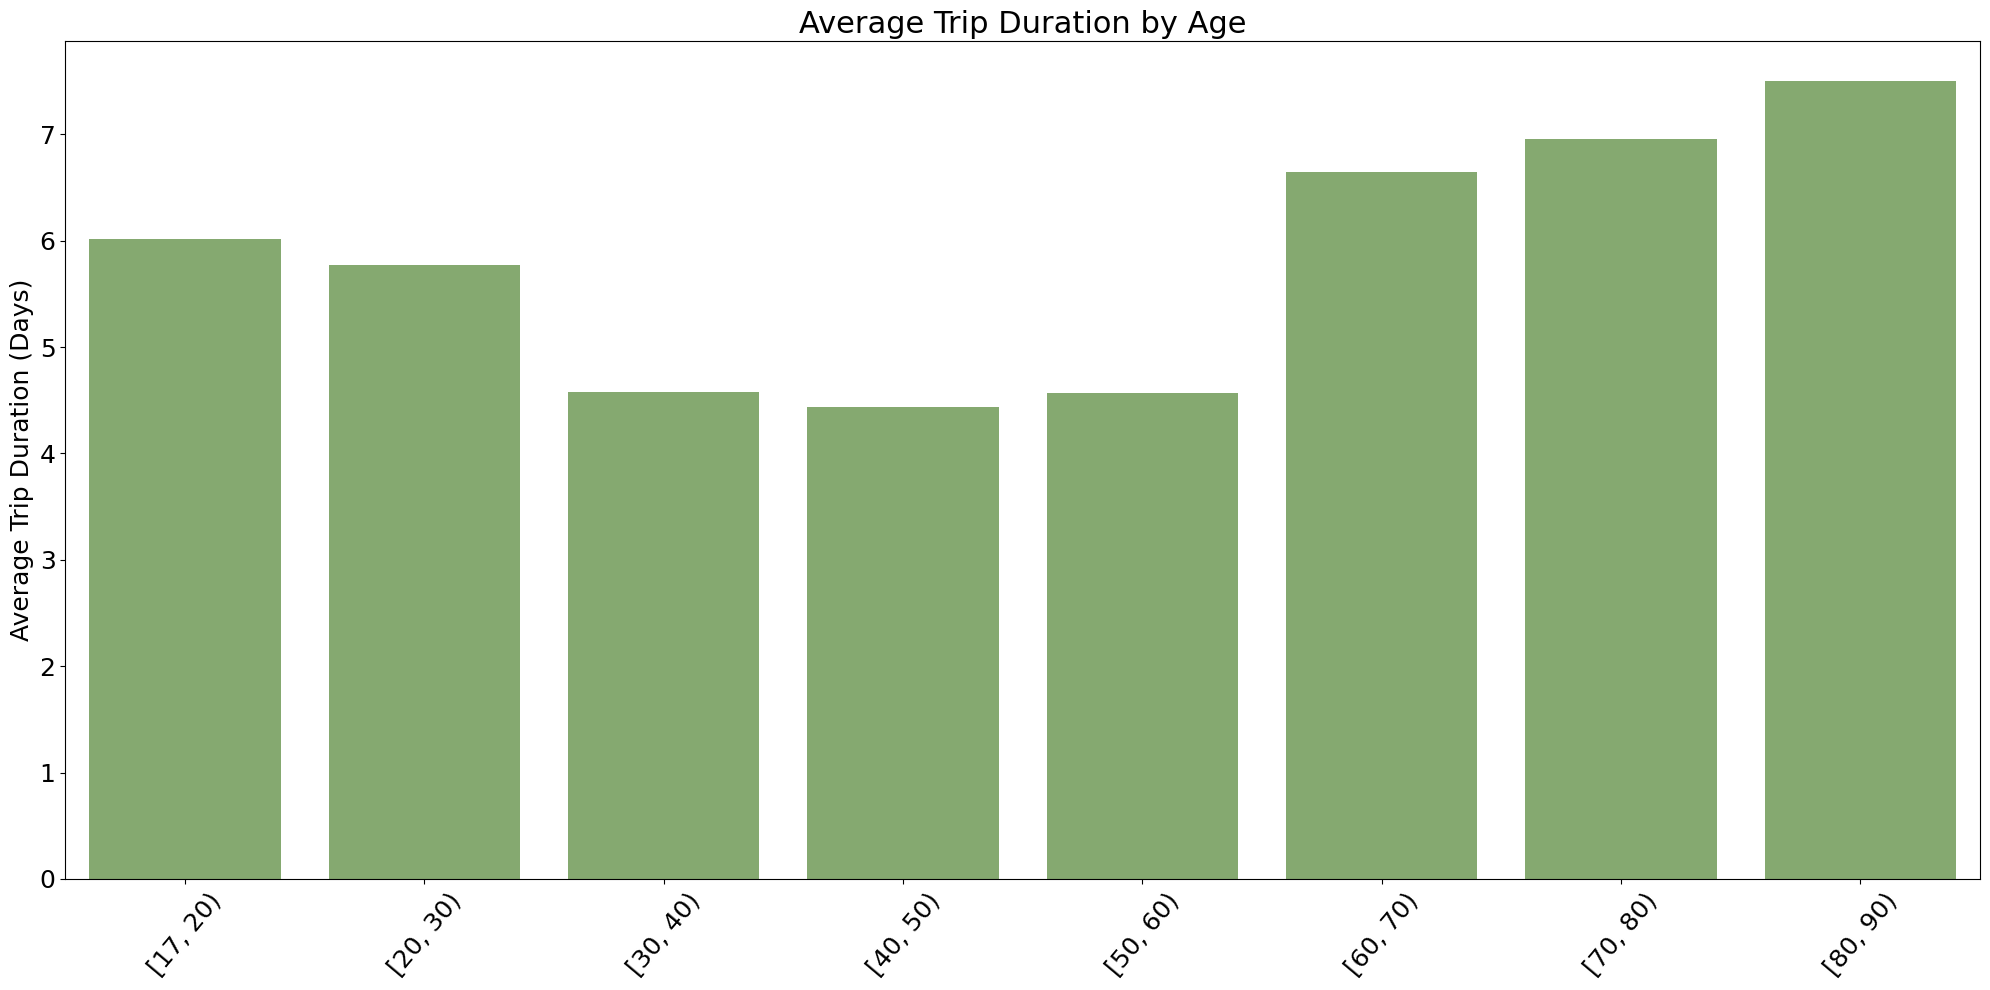

In [0]:
plt.figure(figsize=(20,10))
sns.barplot(data=df, x='age_bin', y='nr_booked_and_travelled', estimator=np.mean, errorbar=None)
plt.xticks(rotation=50, fontsize=18)
plt.xlabel("", fontsize=18)
plt.ylabel("Average number of booked trips", fontsize=18)
plt.title("Average number of booked trip by Age", fontsize=22)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

print('ciao')

plt.figure(figsize=(20,10))
sns.barplot(data=df, x='age_bin', y='duration_avg', estimator=np.mean, errorbar=None, color='#82B366')
plt.xticks(rotation=50, fontsize=18)
plt.xlabel("", fontsize=18)
plt.ylabel("Average Trip Duration (Days)", fontsize=18)
plt.title("Average Trip Duration by Age", fontsize=22)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

In [0]:
AgeBinsDF = df.loc[:,numerical_cols + ['age_in_2023', 'age_bin']]

In [0]:
age_list = [17,20,30,40,50,60,70,80,90] #[17,19,29,39,49,59,69,79]# ,89,99]
categ_features = ['nr_cancellation_session', 'flights_taken', 'hotels_stayed', 'hotel_stayed_nights_avg']

for categ_feat in categ_features:
    print(f'-- {categ_feat} by ages ------------------------------')
    for i in range(len(age_list)-1):
        if age_list[i] == 80:
            break
        i_s = [age_list[i], age_list[i+1], age_list[i+2]]
        a = AgeBinsDF.loc[AgeBinsDF.age_bin == pd.Interval(i_s[0], i_s[1], closed='left'), categ_feat]
        b = AgeBinsDF.loc[AgeBinsDF.age_bin == pd.Interval(i_s[1], i_s[2], closed='left'), categ_feat]
        #print(a)
        #print(b)
        d = np.abs(pg.compute_effsize(a, b, eftype='cohen'))
        print(f"({i_s[0]},{i_s[1]}] vs ({i_s[1]},{i_s[2]}]:  d={d} ({inter_eff(d)})")
    print()

-- nr_cancellation_session by ages ------------------------------
(17,20] vs (20,30]:  d=0.025919471307436156 (negligible)
(20,30] vs (30,40]:  d=0.10282136546975053 (negligible)
(30,40] vs (40,50]:  d=0.0044161227321152085 (negligible)
(40,50] vs (50,60]:  d=0.008876560737266434 (negligible)
(50,60] vs (60,70]:  d=0.036072138552253656 (negligible)
(60,70] vs (70,80]:  d=0.03990495671976087 (negligible)
(70,80] vs (80,90]:  d=0.3992378875888699 (small)

-- flights_taken by ages ------------------------------
(17,20] vs (20,30]:  d=0.5654126141213164 (medium)
(20,30] vs (30,40]:  d=1.0013772894729276 (large)
(30,40] vs (40,50]:  d=0.15815865995105968 (negligible)
(40,50] vs (50,60]:  d=0.1734050563385242 (negligible)
(50,60] vs (60,70]:  d=1.2344168572750682 (large)
(60,70] vs (70,80]:  d=0.5516498036843217 (medium)
(70,80] vs (80,90]:  d=0.01802756123467202 (negligible)

-- hotels_stayed by ages ------------------------------
(17,20] vs (20,30]:  d=0.508826192729875 (medium)
(20,30] vs

### Avg Nr Cancellations

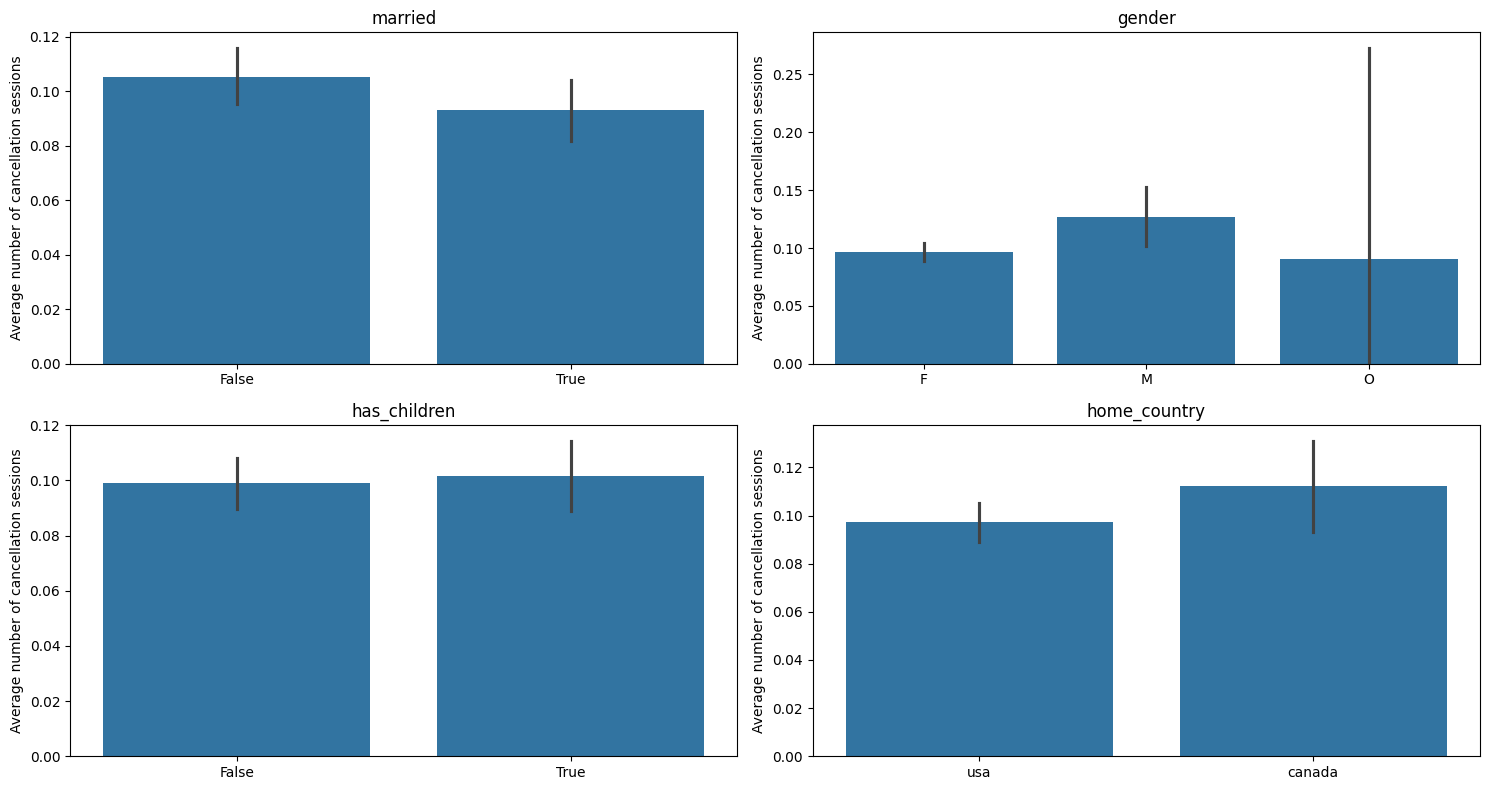

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
categorical_cols = ['married', 'gender', 'has_children', 'home_country']

for i, ax in zip(categorical_cols, axes.flatten()):
    sns.barplot(data=df, x=i, y='nr_cancellation_session', estimator=np.mean, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("Average number of cancellation sessions")
    ax.set_title(i)
plt.tight_layout()
plt.show()

In [0]:
#EFFECT SIZE
for i in categorical_cols:
    effect_size_cont_disc(df, 'nr_cancellation_session', i)
    print()

--- nr_cancellation_session vs married ----------------
False vs True:  d=0.03940236120903073 (negligible)

--- nr_cancellation_session vs gender ----------------
F vs M:  d=0.09873169157492284 (negligible)
F vs O:  d=0.018083345458995127 (negligible)
M vs O:  d=0.10608667168447503 (negligible)

--- nr_cancellation_session vs has_children ----------------
False vs True:  d=0.008563356816068698 (negligible)

--- nr_cancellation_session vs home_country ----------------
usa vs canada:  d=0.048427222279860425 (negligible)



### Avg Flights Taken 

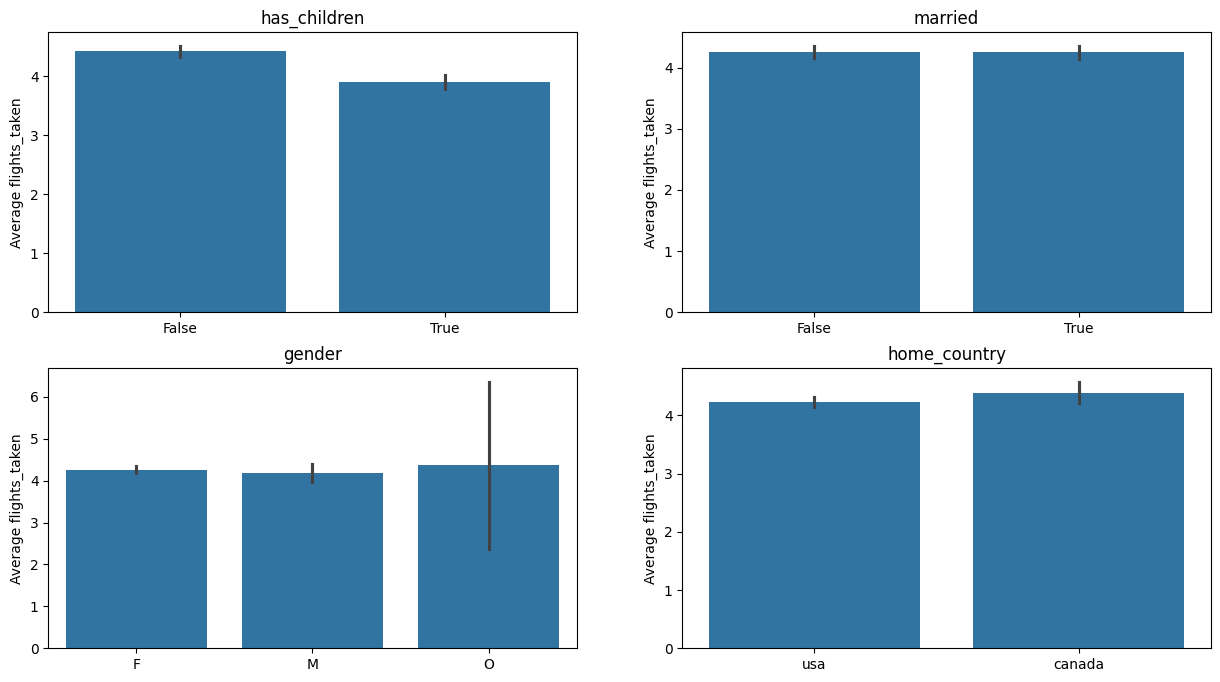

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
categorical_cols = ['has_children', 'married', 'gender', 'home_country']

for i, ax in zip(categorical_cols, axes.flatten()):
    sns.barplot(data=df, x=i, y='flights_taken', estimator=np.mean, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel(f"Average flights_taken")
    ax.set_title(i)
plt.show()

In [0]:
#EFFECT SIZE
for i in categorical_cols:
    effect_size_cont_disc(df, 'flights_taken', i)
    print()

--- flights_taken vs has_children ----------------
False vs True:  d=0.1738496849766999 (negligible)

--- flights_taken vs married ----------------
False vs True:  d=0.001996522990764017 (negligible)

--- flights_taken vs gender ----------------
F vs M:  d=0.02659446225478816 (negligible)
F vs O:  d=0.03416886023635734 (negligible)
M vs O:  d=0.06261489063153168 (negligible)

--- flights_taken vs home_country ----------------
usa vs canada:  d=0.053631262321739225 (negligible)



### Avg Hotel Stayed

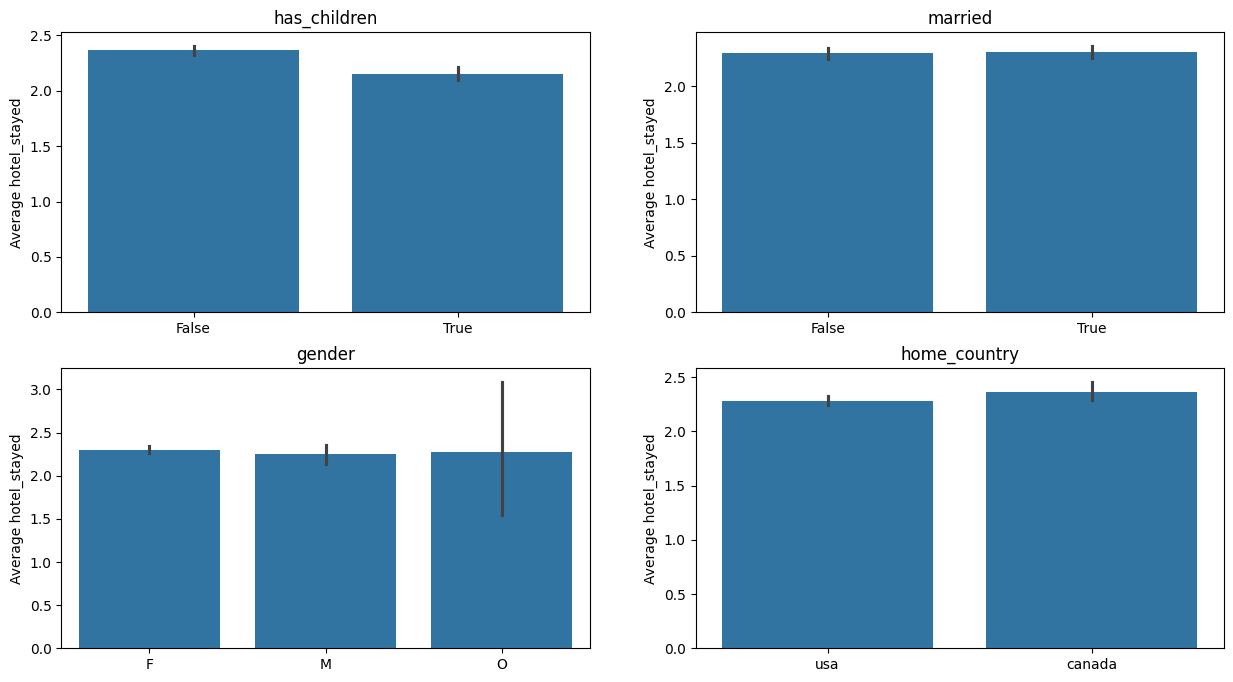

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
categorical_cols = ['has_children', 'married', 'gender', 'home_country']

for i, ax in zip(categorical_cols, axes.flatten()):
    sns.barplot(data=df, x=i, y='hotels_stayed', estimator=np.mean, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel(f"Average hotel_stayed")
    ax.set_title(i)
plt.show()

In [0]:
#EFFECT SIZE
for i in categorical_cols:
    effect_size_cont_disc(df, 'hotels_stayed', i)
    print()

--- hotels_stayed vs has_children ----------------
False vs True:  d=0.14807960324770356 (negligible)

--- hotels_stayed vs married ----------------
False vs True:  d=0.006665507226794619 (negligible)

--- hotels_stayed vs gender ----------------
F vs M:  d=0.03814594733116821 (negligible)
F vs O:  d=0.020762029067510405 (negligible)
M vs O:  d=0.017160444839092927 (negligible)

--- hotels_stayed vs home_country ----------------
usa vs canada:  d=0.05825381124748412 (negligible)



#RFM Segm Perks

In [0]:
fig = px.treemap(
    df,
    path=['RFM_label2']#,  # gerarchia
    #values='value',                     # dimensione dei riquadri
    #color='value',                      # colore (opzionale)
    #color_continuous_scale='Blues'
)

fig.show()


champion (high R, high F, high M) \
lost (low R, low F, low M)\
need attention (low R, high F, high M)\
inactive (no purchase)\
dormant / one-timer (low R, low F, high M)\
new / need attention (high R, low F, low M)\
at risk (low R, high F, low M)\
high potential (high R, low F, high M)\
loyal (high R, high F, low M)

**Champions**

For Champion users, the strategy should focus on **privileges rather than discounts**.
Instead of lowering prices and eroding margins, we offer benefits that make the experience more exclusive and frictionless at low cost for the platform.
Examples include early access to flight or hotel deals, priority availability for extra services (early check-in / late check-out), priority customer support via chat, and faster handling of changes, refunds, or travel issues.
These privileges reinforce loyalty and perceived value without incentivizing price sensitivity.


**Loyal**

For loyal customers (high R and F, low M), the goal is to encourage higher spend without using discounts. Instead, simplify their experience and offer helpful options during booking.
- Micro-upsell: small add-ons the customer may need, sold at full price.
Examples: extra baggage, late/early check-in, travel insurance, priority support.
- Bundle: combine multiple services into one convenient package to encourage additional purchases, without discounting.
Examples: flight + hotel, hotel + room upgrade + flexible check-out, weekend trip + city tour.

The focus is on making it easy to buy more while improving the experience.

**High-Potential**

no direct discounts are recommended since they already spend a lot. Instead, small incentives can be used to encourage more frequent bookings. Key strategies include:

- Repeat-purchase benefits – offer small perks or upgrades after a certain number of bookings.
Example: “After 3 bookings, enjoy a free room upgrade or lounge access.”
- Time-limited offers / early-bird perks – encourage quick action by providing minor advantages for booking within a set period.
Example: “Book within the next 7 days and get priority check-in or an included local activity.”
- Targeted communications – increase email or push notifications to remind them of destinations they like or suggest similar trips, stimulating repeat bookings.
Example: Personalized emails highlighting trips similar to those they previously enjoyed.

**New / Need Attention**

These customers are either new users or returning after a period of inactivity. The main goal is to encourage them to make their first few purchases and start becoming regular users. Key strategies include:

- Incentives on first purchases – small perks or minor discounts to motivate initial bookings.
Example: free check-in priority, a small activity included, or a minor upgrade on the first trip.
- Onboarding and simplification – guide them step by step through the platform, showing how to book easily and highlighting available services.
Example: tutorials, pop-ups with recommendations, or clear reminders of previously viewed offers.
- Personalized communications – targeted emails or push notifications to remind them of their recent interests and suggest similar trips.
Example: “You viewed Paris—here are 3 similar offers available this week.”

**Need Attention**

These are users who have been very active and high-spending in the past, but haven’t engaged recently, so they are at risk of churn. The goal is to re-engage them without hurting margins. Strategies include:
- Time-limited offers – Encourage them to return quickly with short-term promotions.
- Targeted small discounts – Light, personalized discounts (e.g., 5–10% or an upgrade) to prevent churn.
- Privileges and simplified experience – Priority support, early access to bookings, faster handling of changes and refunds.
- Personalized reminders – Emails highlighting past trips, favorite destinations, or exclusive experiences to re-capture interest.

**At Risk**

These users have purchased fairly often in the past but haven’t engaged recently, and their average spend is low. They are at risk of churn, so the goal is to reactivate them and increase engagement. Strategies include:
- Short-term targeted offers – Small, time-limited incentives to encourage immediate return.
- Personalized campaigns – Emails or notifications reminding them of past trips, relevant packages, or similar destinations.
- Micro-privileges / ease of use – Small perks that improve the booking experience (priority check-in, fast support).

Unlike “Need Attention” users, light discounts are appropriate here because their monetary value is low, so small incentives can motivate repeat bookings without heavily affecting margins.

**Dormant / One-Timer**

Users in this segment can be of two types, and therefore require two slightly different strategies:

- At-risk few-timers – users who historically made few trips and are showing signs of disengagement. For them, small tangible incentives such as limited-time discounts or vouchers for their next trip can help retain them. Complement this with personalized, targeted communication and simplified booking experiences, suggesting ready-made trips similar to their past bookings.
- Occasional high-value travelers – users who travel infrequently but spend significantly on each trip. They should not receive discounts, but can be offered light privileges and extra services (e.g., flexible check-in/out, priority support). Again, use personalized, inspirational communication and simplify the booking process through suggested packages or pre-built itineraries.

The common thread: personalization, simplicity, and targeted communication, with the type of incentive adapted to the user subtype.

**Lost**

Users in the Lost segment have low recency, frequency, and monetary value, and are largely disengaged. Strategies for them should focus on targeted, cost-effective interventions:

- Significant offers or vouchers, but only if the potential return justifies the investment, since their expected value is low.
- Light, motivational communication: occasional emails or notifications highlighting new trips, experiences, or limited-time offers, without overwhelming them.

The key is to invest cautiously and selectively, recognizing that many of these users may be permanently lost.

**Inactive (no purchase)** 

Users who haven’t made any purchases yet. Focus on guiding them to their first booking:

- Targeted communication & onboarding: Explain how the platform works, highlight key features.
- Ready-to-book packages: Suggest curated travel packages to simplify decision-making.
- Small privileges or first-purchase incentives: E.g., minor upgrades, early access to offers, or a small voucher for the first booking.

Goal: make the first experience easy and appealing, encouraging conversion without heavy discounts.

In [0]:
df.RFM_label2.value_counts()

RFM_label2
champion                1427
lost                    1350
need attention          1144
inactive                 564
dormant / one-timer      486
new / need attention     356
at risk                  276
high potential           203
loyal                    192
Name: count, dtype: int64

# Booking & Travel Behaviour segmentation

In [0]:
df.head(5)

,user_id,nr_sessions,date_last_booking_travelled,page_clicks_tot,page_clicks_avg,flights_taken,hotels_stayed,nr_booked_and_travelled,nr_booked_but_cancelled,nr_cancellation_session,nr_no_booking,flight_taken_discount_avg,flight_taken_discount_nr,hotel_stayed_discount_avg,hotel_stayed_discount_nr,hotel_and_flight_discount_nr,flight_taken_price_avg,hotel_stayed_room_price_per_night_avg,hotel_stayed_nights_avg,nr_airlines_taken,distance_km_tot,distance_km_avg,duration_tot,duration_avg,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,age_in_2023,age_bin,user_spend_tot,user_spend_avg,booking_window_days_avg,booking_window_days_min,booking_window_days_max,family_travelled_trip_nr,non_family_travelled_trip_nr,R_score,F_score,M_score,RFM_score,RFM_label,RFM_label2,family_user
0,23557,8,2023-07-14 12:36:00,82,10.250,0,2,2,0,0,6,NaN,0,0.25,1,0,NaN,177.0,10.0,0,NaN,NaN,20.0,10.0,1958-12-08,F,True,False,usa,new york,LGA,40.777,-73.872,2021-07-22,65,"[60, 70)",3802.00,1901.000,12.815833,10.932535,14.699132,0,2,5.0,2,4.0,11.0,high potential,high potential,False
1,94883,8,2023-04-10 21:13:00,73,9.125,4,2,2,0,0,6,NaN,0,NaN,0,0,432.045,90.0,1.0,2,2907.336271,1453.668135,3.0,1.5,1972-03-16,F,True,False,usa,kansas city,MCI,39.297,-94.714,2022-02-07,51,"[50, 60)",1094.09,547.045,7.151759,5.530370,8.773148,0,2,2.0,2,1.0,5.0,lost,lost,False
2,101486,8,2023-06-17 19:42:00,131,16.375,2,2,2,0,0,6,NaN,0,NaN,0,0,189.910,198.5,4.5,1,965.341901,965.341901,9.0,4.5,1972-12-07,F,True,True,usa,tacoma,TCM,47.138,-122.476,2022-02-17,51,"[50, 60)",2641.91,1320.955,7.837760,6.635683,9.039838,1,1,4.0,2,3.0,9.0,new customer,high potential,True
3,101961,8,2023-06-22 13:27:00,126,15.750,10,5,5,0,0,3,0.1,1,NaN,0,0,248.532,136.0,4.4,5,6608.430041,1321.686008,24.0,4.8,1980-09-14,F,True,False,usa,boston,BOS,42.364,-71.005,2022-02-17,43,"[40, 50)",4040.66,808.132,6.257370,3.542292,10.645613,0,5,4.0,5,4.0,13.0,champion,champion,False
4,106907,8,NaT,240,30.000,0,0,0,1,1,6,NaN,0,NaN,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1978-11-17,F,True,True,usa,miami,TNT,25.862,-80.897,2022-02-24,45,"[40, 50)",NaN,NaN,NaN,NaN,NaN,0,0,NaN,1,NaN,NaN,inactive,inactive,False


In [0]:
df.columns

Index(['user_id', 'nr_sessions', 'date_last_booking_travelled',
       'page_clicks_tot', 'page_clicks_avg', 'flights_taken', 'hotels_stayed',
       'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'flight_taken_discount_nr', 'hotel_stayed_discount_avg',
       'hotel_stayed_discount_nr', 'hotel_and_flight_discount_nr',
       'flight_taken_price_avg', 'hotel_stayed_room_price_per_night_avg',
       'hotel_stayed_nights_avg', 'nr_airlines_taken', 'distance_km_tot',
       'distance_km_avg', 'duration_tot', 'duration_avg', 'birthdate',
       'gender', 'married', 'has_children', 'home_country', 'home_city',
       'home_airport', 'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'age_in_2023', 'age_bin', 'user_spend_tot', 'user_spend_avg',
       'booking_window_days_avg', 'booking_window_days_min',
       'booking_window_days_max', 'family_travelled_trip_nr',
       'non_family_tra

##Discount seekers

In [0]:
#users that have >60% of their trips with an applied discount (and that has more than 1 booked trip)
perc = 60
discount_seeker = df[(df.nr_booked_and_travelled > 1) & ((df.flight_taken_discount_nr / df.nr_booked_and_travelled * 100 > perc) | (df.hotel_stayed_discount_nr / df.nr_booked_and_travelled * 100 > perc))]['user_id']
discount_seeker.shape

(239,)

In [0]:
df[df.user_id.isin(discount_seeker)]['family_user'].value_counts()

family_user
False    209
True      30
Name: count, dtype: int64

## Engagement Level

In [0]:
low_activity = df[df.nr_booked_and_travelled <= 2]['user_id']
low_activity.shape

(2959,)

In [0]:
high_activity = df[df.nr_booked_and_travelled > 2]['user_id']
high_activity.shape

(3039,)

## Trip Length

In [0]:
df[df.user_id.isin(high_activity)]['duration_avg'].describe()

count    3039.000000
mean        4.528104
std         1.828082
min         1.250000
25%         3.333333
50%         4.000000
75%         5.400000
max        21.000000
Name: duration_avg, dtype: float64

In [0]:
short_trip_HA = df[(df.user_id.isin(high_activity)) & (df.duration_avg < 3)]['user_id']
short_trip_HA.shape

(411,)

In [0]:
long_trip_HA = df[(df.user_id.isin(high_activity)) & (df.duration_avg > 7)]['user_id']
long_trip_HA.shape

(230,)

In [0]:
long_trip_LA = df[(df.user_id.isin(low_activity)) & (df.duration_avg > 7)]['user_id']
long_trip_LA.shape

(425,)

In [0]:
medium_trip_HA = df[
    (df.user_id.isin(high_activity)) &
    (~df.user_id.isin(long_trip_HA)) &
    (~df.user_id.isin(short_trip_HA))
]['user_id']
medium_trip_HA.shape

(2398,)

In [0]:
411+83+2545

3039

In [0]:
common_user_ids = set(medium_trip_HA).intersection(set(high_activity))
len(common_user_ids)

2398

## Booking modality (Last minute or not)

In [0]:
df[df.user_id.isin(high_activity)]['booking_window_days_avg'].describe()

count    3039.000000
mean       10.160603
std        13.518926
min         3.765818
25%         6.637068
50%         7.594252
75%         8.645971
max       128.365660
Name: booking_window_days_avg, dtype: float64

In [0]:
last_minute_HA = df[(df.user_id.isin(high_activity)) & (df.booking_window_days_avg < 7)]['user_id']
last_minute_HA.shape

(1032,)

In [0]:
planner_HA = df[(df.user_id.isin(high_activity)) & (df.booking_window_days_avg >= 7)]['user_id']
planner_HA.shape

(2007,)

##Final

In [0]:
long_trip_LA.shape

(425,)

In [0]:
short_medium_trip_LA = low_activity[~low_activity.isin(long_trip_LA)]
short_medium_trip_LA.shape

(2534,)

In [0]:
short_last_minute_HA = short_trip_HA[short_trip_HA.isin(last_minute_HA)]
short_last_minute_HA.shape

(141,)

In [0]:
short_planner_HA = short_trip_HA[~short_trip_HA.isin(last_minute_HA)]
short_planner_HA.shape

(270,)

In [0]:
long_last_minute_HA = long_trip_HA[long_trip_HA.isin(last_minute_HA)]
long_last_minute_HA.shape

(71,)

In [0]:
long_planner_HA = long_trip_HA[~long_trip_HA.isin(last_minute_HA)]
long_planner_HA.shape

(159,)

In [0]:
medium_last_minute_HA = medium_trip_HA[medium_trip_HA.isin(last_minute_HA)]
medium_last_minute_HA.shape

(820,)

In [0]:
medium_planner_HA = medium_trip_HA[~medium_trip_HA.isin(last_minute_HA)]
medium_planner_HA.shape

(1578,)

In [0]:
medium_planner_HA.head()

5     118043
7     125845
17    175032
20    187212
22    190866
Name: user_id, dtype: int64

In [0]:
series_dict = {
    'occasional long-trip':long_trip_LA,
    'low-engaged':short_medium_trip_LA,

    'spontaneous short-trip':short_last_minute_HA,
    'spontaneous regular-trip':medium_last_minute_HA,
    'spontaneous long-trip':long_last_minute_HA,

    'short-trip':short_planner_HA,
    'regular-trip':medium_planner_HA,
    'long-trip':long_planner_HA
}

def segm_assign(row):
    for key, value in series_dict.items():
        if row['user_id'] in value.values:
            return key

In [0]:
df['manual_segments'] = df.apply(lambda row: segm_assign(row), axis=1)
df['manual_segments'].value_counts()

manual_segments
low-engaged                 2534
regular-trip                1578
spontaneous regular-trip     820
occasional long-trip         425
short-trip                   270
long-trip                    159
spontaneous short-trip       141
spontaneous long-trip         71
Name: count, dtype: int64

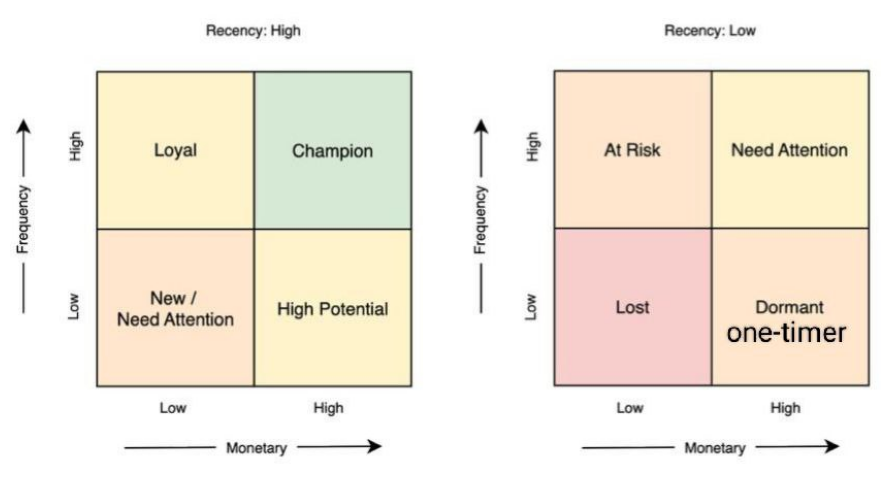

In [0]:
img_path = '/Workspace/Users/filippopedrini95@gmail.com/RFM diagr2.jpeg'  # update with the correct path
img = Image.open(img_path)
plt.figure(figsize=(20, 6))  # change the size here (width, height)
plt.imshow(img)
plt.axis('off')
plt.show()

champion (high R, high F, high M) \
lost (low R, low F, low M)\
need attention (low R, high F, high M)\
inactive (no purchase)\
dormant / one-timer (low R, low F, high M)\
new / need attention (high R, low F, low M)\
at risk (low R, high F, low M)\
high potential (high R, low F, high M)\
loyal (high R, high F, low M)

In [0]:
fig = px.treemap(
    df,
    path=['RFM_label2', 'manual_segments']  # gerarchia
    #values='value',                     # dimensione dei riquadri
    #color='value',                      # colore (opzionale)
    #color_continuous_scale='Blues'
)

fig.show()

In [0]:
concatenated_last_minute_HA = pd.concat([short_last_minute_HA, medium_last_minute_HA, long_last_minute_HA], axis=0)
concatenated_last_minute_HA = concatenated_last_minute_HA.reset_index(drop=True)

concatenated_planner_HA = pd.concat([short_planner_HA, medium_planner_HA, long_planner_HA], axis=0)
concatenated_planner_HA = concatenated_planner_HA.reset_index(drop=True)

In [0]:
series_dict = {
    'occasional long-trip':long_trip_LA,
    'low-engaged':short_medium_trip_LA,
    'last-minute booker': concatenated_last_minute_HA,
    'planned booker': concatenated_planner_HA
}

def segm_assign_HighLevel(row):
    for key, value in series_dict.items():
        if row['user_id'] in value.values:
            return key

In [0]:
df['manual_segments_HighLevel'] = df.apply(lambda row: segm_assign_HighLevel(row), axis=1)
df['manual_segments_HighLevel'].value_counts()

manual_segments_HighLevel
low-engaged             2534
planned booker          2007
last-minute booker      1032
occasional long-trip     425
Name: count, dtype: int64

In [0]:
df.columns

Index(['user_id', 'nr_sessions', 'date_last_booking_travelled',
       'page_clicks_tot', 'page_clicks_avg', 'flights_taken', 'hotels_stayed',
       'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'flight_taken_discount_nr', 'hotel_stayed_discount_avg',
       'hotel_stayed_discount_nr', 'hotel_and_flight_discount_nr',
       'flight_taken_price_avg', 'hotel_stayed_room_price_per_night_avg',
       'hotel_stayed_nights_avg', 'nr_airlines_taken', 'distance_km_tot',
       'distance_km_avg', 'duration_tot', 'duration_avg', 'birthdate',
       'gender', 'married', 'has_children', 'home_country', 'home_city',
       'home_airport', 'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'age_in_2023', 'age_bin', 'user_spend_tot', 'user_spend_avg',
       'booking_window_days_avg', 'booking_window_days_min',
       'booking_window_days_max', 'family_travelled_trip_nr',
       'non_family_tra

#Chart for Presentation

In [0]:
fig = px.treemap(
    df,
    path=['RFM_label2', 'manual_segments_HighLevel']  # gerarchia
    #values='value',                     # dimensione dei riquadri
    #color='value',                      # colore (opzionale)
    #color_continuous_scale='Blues'
)

fig.update_layout(
    width=1200,
    height=600)

fig.show()

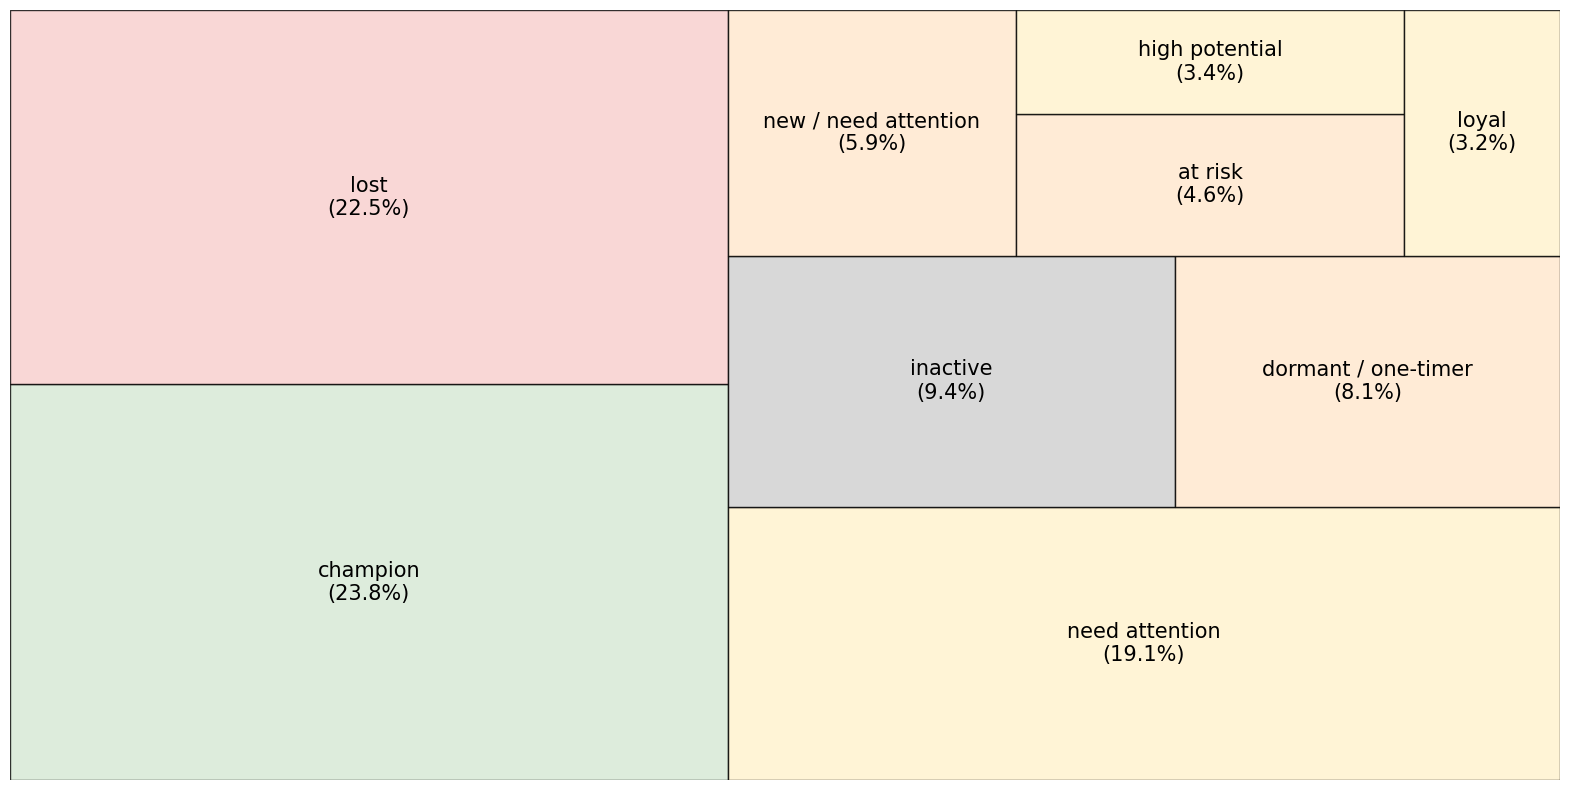

In [0]:
rfm_counts = df['RFM_label2'].value_counts()
labels = rfm_counts.index.tolist()
sizes = rfm_counts.values.tolist()
total = sum(sizes)
labels_with_pct = [f"{label}\n({size/total:.1%})" for label, size in zip(labels, sizes)]

colors = []
for label in labels:
    if label == "champion":
        colors.append("#D5E8D4")
    elif label in ["loyal", "high potential", "need attention"]:
        colors.append("#FFF2CC")
    elif label in ["new / need attention", "at risk", "dormant / one-timer"]:
        colors.append("#FFE6CC")
    elif label in ["lost"]:
        colors.append("#F8CECC")
    else:
        colors.append("#cfcfcf")  # colore di default per gli altri

plt.figure(figsize=(20, 10))
squarify.plot(
    sizes=sizes, 
    label=labels_with_pct, 
    color=colors, 
    alpha=0.8, 
    edgecolor='black', 
    linewidth=1,
    text_kwargs={'fontsize': 15}  # modifica la dimensione delle label
)
plt.axis('off')
plt.title('')
plt.show()

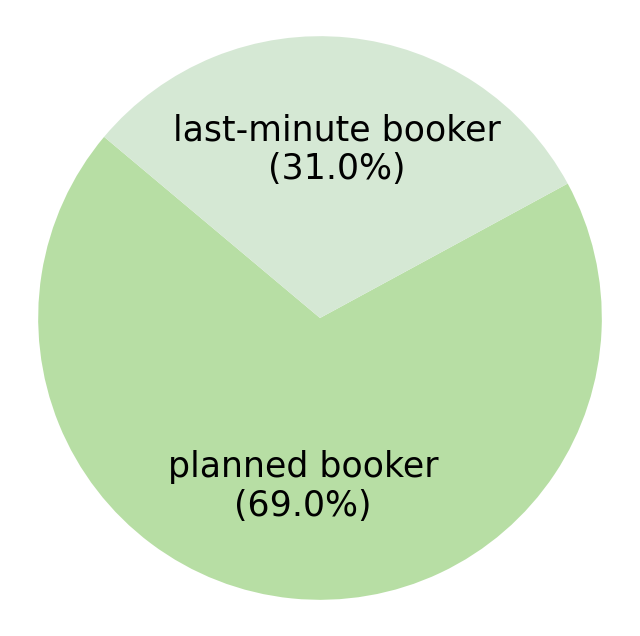

In [0]:
champion_segments = df.loc[df.RFM_label2 == 'champion', 'manual_segments_HighLevel'].value_counts()
labels = champion_segments.index.tolist()
sizes = champion_segments.values.tolist()
total = sum(sizes)
labels_with_pct = [f"{label}\n({size/total:.1%})" for label, size in zip(labels, sizes)]

# Set colors for specific labels
colors = []
for label in labels:
    if label == "last-minute booker":
        colors.append("#D5E8D4")
    elif label == "planned booker":
        colors.append("#B7DEA4")
    else:
        colors.append("#cfcfcf")  # default color

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=None, 
    colors=colors,
    autopct=lambda pct: labels_with_pct.pop(0), 
    startangle=140
)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(25)
plt.axis('equal')
plt.title("")
plt.show()

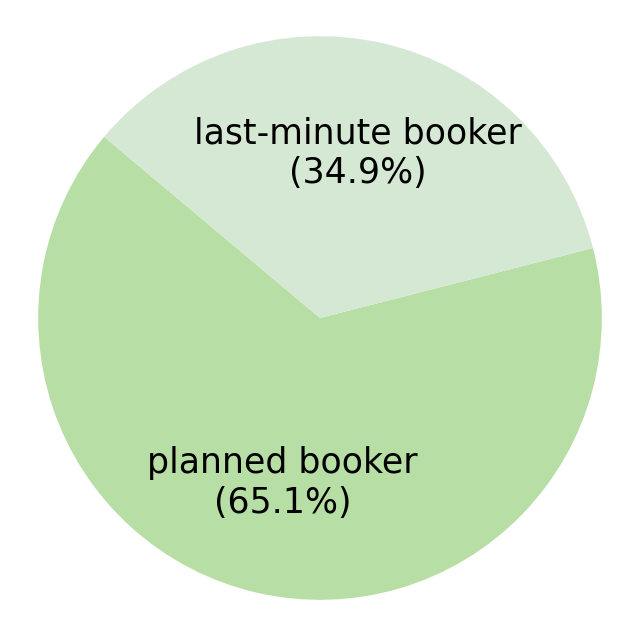

In [0]:
champion_segments = df.loc[df.RFM_label2 == 'loyal', 'manual_segments_HighLevel'].value_counts()
labels = champion_segments.index.tolist()
sizes = champion_segments.values.tolist()
total = sum(sizes)
labels_with_pct = [f"{label}\n({size/total:.1%})" for label, size in zip(labels, sizes)]

# Set colors for specific labels
colors = []
for label in labels:
    if label == "last-minute booker":
        colors.append("#D5E8D4")
    elif label == "planned booker":
        colors.append("#B7DEA4")
    else:
        colors.append("#cfcfcf")  # default color

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=None, 
    colors=colors,
    autopct=lambda pct: labels_with_pct.pop(0), 
    startangle=140
)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(25)
plt.axis('equal')
plt.title("")
plt.show()

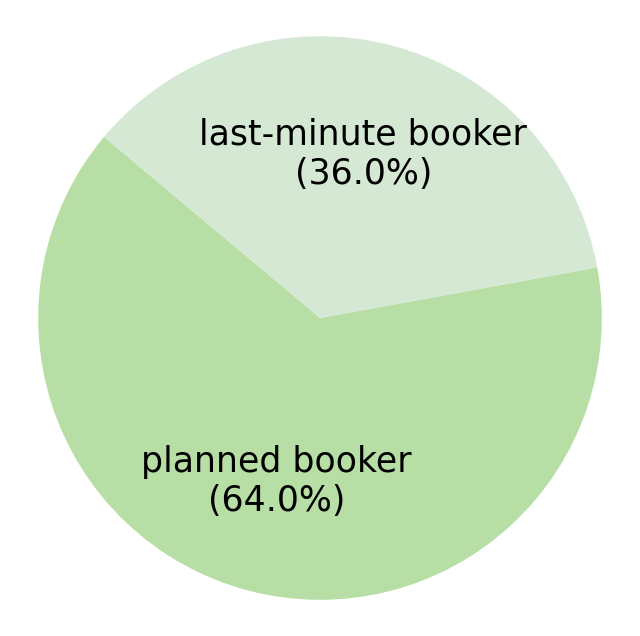

In [0]:
champion_segments = df.loc[df.RFM_label2 == 'need attention', 'manual_segments_HighLevel'].value_counts()
labels = champion_segments.index.tolist()
sizes = champion_segments.values.tolist()
total = sum(sizes)
labels_with_pct = [f"{label}\n({size/total:.1%})" for label, size in zip(labels, sizes)]

# Set colors for specific labels
colors = []
for label in labels:
    if label == "last-minute booker":
        colors.append("#D5E8D4")
    elif label == "planned booker":
        colors.append("#B7DEA4")
    else:
        colors.append("#cfcfcf")  # default color

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=None, 
    colors=colors,
    autopct=lambda pct: labels_with_pct.pop(0), 
    startangle=140
)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(25)
plt.axis('equal')
plt.title("")
plt.show()

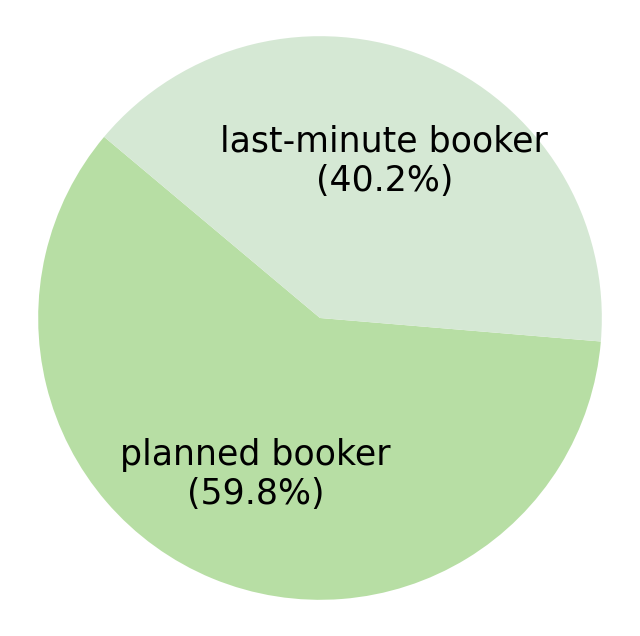

In [0]:
champion_segments = df.loc[df.RFM_label2 == 'at risk', 'manual_segments_HighLevel'].value_counts()
labels = champion_segments.index.tolist()
sizes = champion_segments.values.tolist()
total = sum(sizes)
labels_with_pct = [f"{label}\n({size/total:.1%})" for label, size in zip(labels, sizes)]

# Set colors for specific labels
colors = []
for label in labels:
    if label == "last-minute booker":
        colors.append("#D5E8D4")
    elif label == "planned booker":
        colors.append("#B7DEA4")
    else:
        colors.append("#cfcfcf")  # default color

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=None, 
    colors=colors,
    autopct=lambda pct: labels_with_pct.pop(0), 
    startangle=140
)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(25)
plt.axis('equal')
plt.title("")
plt.show()

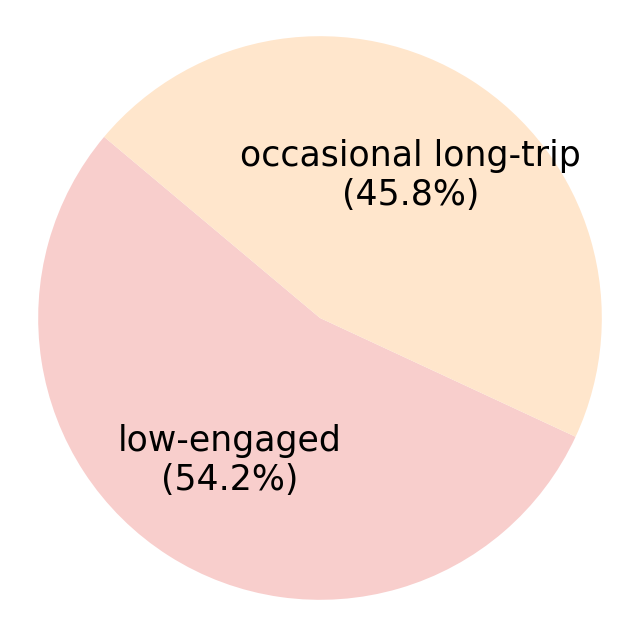

In [0]:
champion_segments = df.loc[df.RFM_label2 == 'high potential', 'manual_segments_HighLevel'].value_counts()
labels = champion_segments.index.tolist()
sizes = champion_segments.values.tolist()
total = sum(sizes)
labels_with_pct = [f"{label}\n({size/total:.1%})" for label, size in zip(labels, sizes)]

# Set colors for specific labels
colors = []
for label in labels:
    if label == "low-engaged":
        colors.append("#F8CECC")
    elif label == "occasional long-trip":
        colors.append("#FFE6CC")
    else:
        colors.append("#cfcfcf")  # default color

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=None, 
    colors=colors,
    autopct=lambda pct: labels_with_pct.pop(0), 
    startangle=140
)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(25)
plt.axis('equal')
plt.title("")
plt.show()

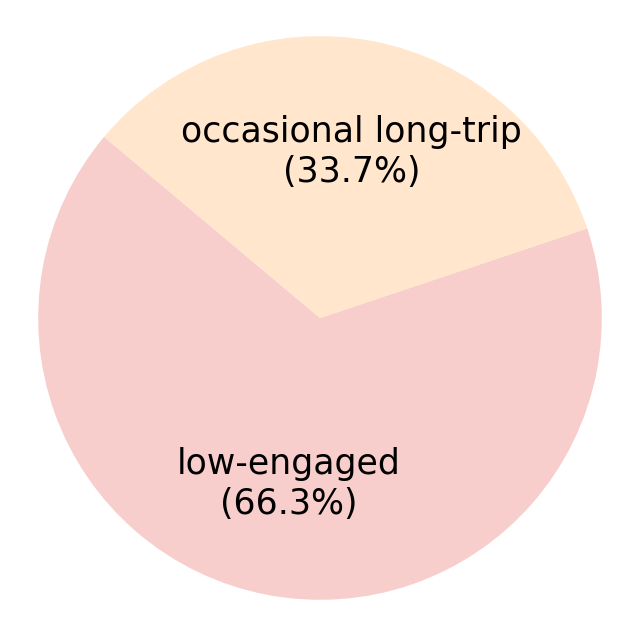

In [0]:
champion_segments = df.loc[df.RFM_label2 == 'dormant / one-timer', 'manual_segments_HighLevel'].value_counts()
labels = champion_segments.index.tolist()
sizes = champion_segments.values.tolist()
total = sum(sizes)
labels_with_pct = [f"{label}\n({size/total:.1%})" for label, size in zip(labels, sizes)]

# Set colors for specific labels
colors = []
for label in labels:
    if label == "low-engaged":
        colors.append("#F8CECC")
    elif label == "occasional long-trip":
        colors.append("#FFE6CC")
    else:
        colors.append("#cfcfcf")  # default color

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=None, 
    colors=colors,
    autopct=lambda pct: labels_with_pct.pop(0), 
    startangle=140
)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(25)
plt.axis('equal')
plt.title("")
plt.show()

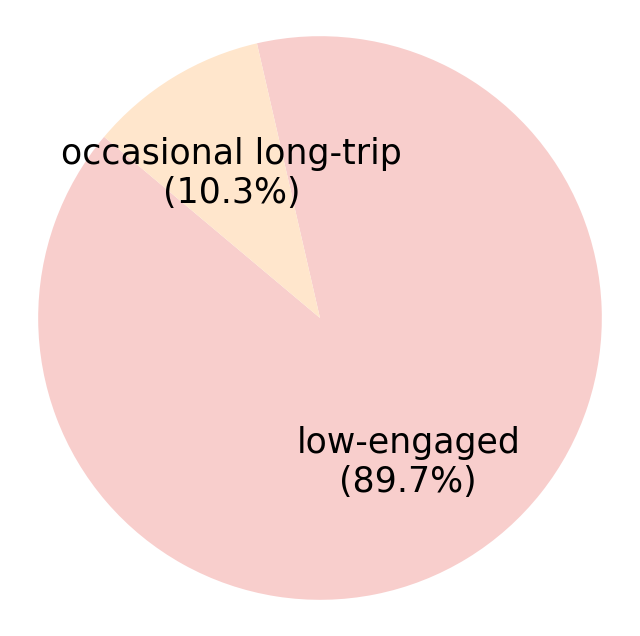

In [0]:
champion_segments = df.loc[df.RFM_label2 == 'lost', 'manual_segments_HighLevel'].value_counts()
labels = champion_segments.index.tolist()
sizes = champion_segments.values.tolist()
total = sum(sizes)
labels_with_pct = [f"{label}\n({size/total:.1%})" for label, size in zip(labels, sizes)]

# Set colors for specific labels
colors = []
for label in labels:
    if label == "low-engaged":
        colors.append("#F8CECC")
    elif label == "occasional long-trip":
        colors.append("#FFE6CC")
    else:
        colors.append("#cfcfcf")  # default color

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=None, 
    colors=colors,
    autopct=lambda pct: labels_with_pct.pop(0), 
    startangle=140
)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(25)
plt.axis('equal')
plt.title("")
plt.show()

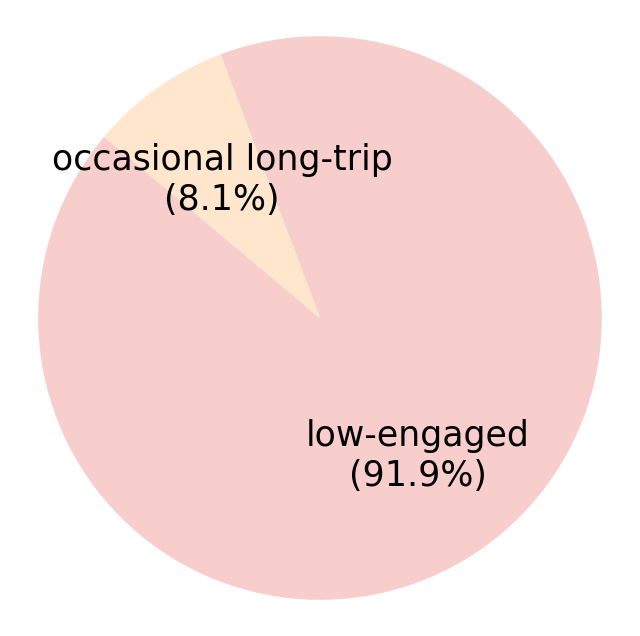

In [0]:
champion_segments = df.loc[df.RFM_label2 == 'new / need attention', 'manual_segments_HighLevel'].value_counts()
labels = champion_segments.index.tolist()
sizes = champion_segments.values.tolist()
total = sum(sizes)
labels_with_pct = [f"{label}\n({size/total:.1%})" for label, size in zip(labels, sizes)]

# Set colors for specific labels
colors = []
for label in labels:
    if label == "low-engaged":
        colors.append("#F8CECC")
    elif label == "occasional long-trip":
        colors.append("#FFE6CC")
    else:
        colors.append("#cfcfcf")  # default color

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=None, 
    colors=colors,
    autopct=lambda pct: labels_with_pct.pop(0), 
    startangle=140
)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(25)
plt.axis('equal')
plt.title("")
plt.show()

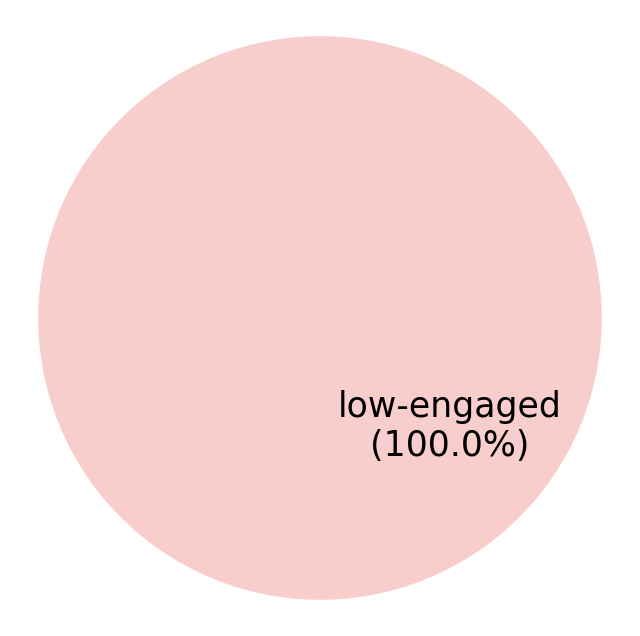

In [0]:
champion_segments = df.loc[df.RFM_label2 == 'inactive', 'manual_segments_HighLevel'].value_counts()
labels = champion_segments.index.tolist()
sizes = champion_segments.values.tolist()
total = sum(sizes)
labels_with_pct = [f"{label}\n({size/total:.1%})" for label, size in zip(labels, sizes)]

# Set colors for specific labels
colors = []
for label in labels:
    if label == "low-engaged":
        colors.append("#F8CECC")
    elif label == "occasional long-trip":
        colors.append("#FFE6CC")
    else:
        colors.append("#cfcfcf")  # default color

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=None, 
    colors=colors,
    autopct=lambda pct: labels_with_pct.pop(0), 
    startangle=140
)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(25)
plt.axis('equal')
plt.title("")
plt.show()

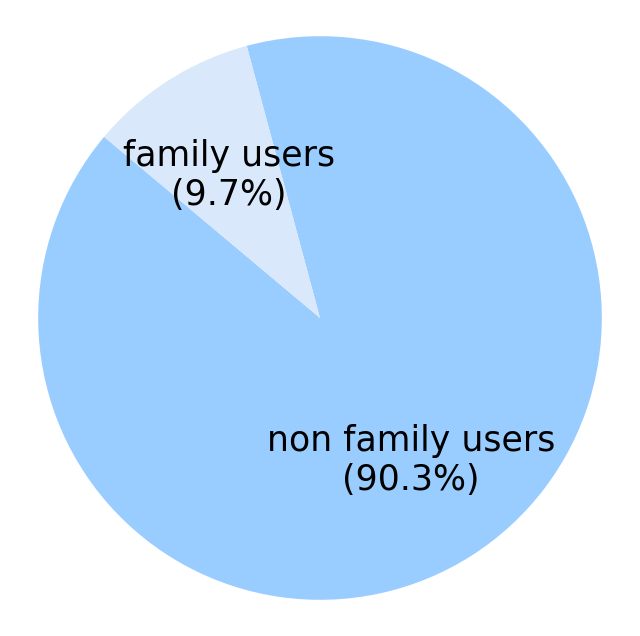

In [0]:
family_counts = df['family_user'].value_counts()
labels = ['family users' if label else 'non family users' for label in family_counts.index.tolist()]
sizes = family_counts.values.tolist()
total = sum(sizes)
labels_with_pct = [f"{label}\n({size/total:.1%})" for label, size in zip(labels, sizes)]

colors = ["#99CCFF", "#DAE8FC"]  # family users, non family users

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=None, 
    colors=colors,
    autopct=lambda pct: labels_with_pct.pop(0), 
    startangle=140
)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(25)
plt.axis('equal')
plt.title("")
plt.show()

In [0]:
df.columns

Index(['user_id', 'nr_sessions', 'date_last_booking_travelled',
       'page_clicks_tot', 'page_clicks_avg', 'flights_taken', 'hotels_stayed',
       'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'flight_taken_discount_nr', 'hotel_stayed_discount_avg',
       'hotel_stayed_discount_nr', 'hotel_and_flight_discount_nr',
       'flight_taken_price_avg', 'hotel_stayed_room_price_per_night_avg',
       'hotel_stayed_nights_avg', 'nr_airlines_taken', 'distance_km_tot',
       'distance_km_avg', 'duration_tot', 'duration_avg', 'birthdate',
       'gender', 'married', 'has_children', 'home_country', 'home_city',
       'home_airport', 'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'age_in_2023', 'age_bin', 'user_spend_tot', 'user_spend_avg',
       'booking_window_days_avg', 'booking_window_days_min',
       'booking_window_days_max', 'family_travelled_trip_nr',
       'non_family_tra

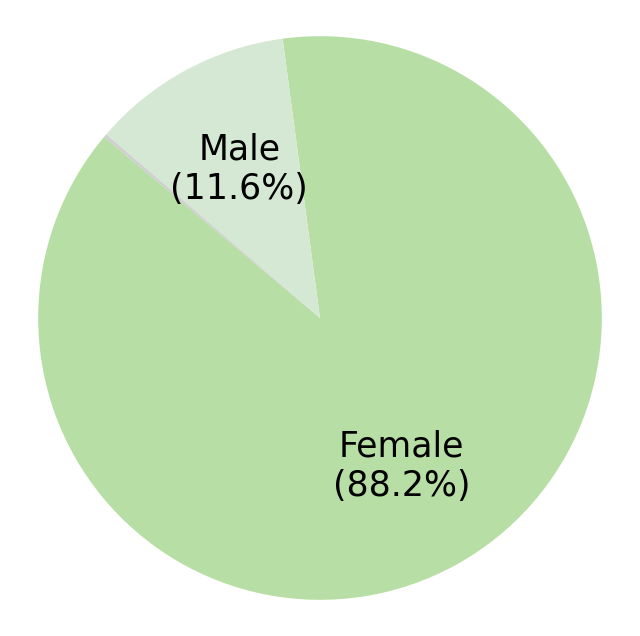

In [0]:
gender_counts = df['gender'].value_counts()
labels = gender_counts.index.tolist()
sizes = gender_counts.values.tolist()
total = sum(sizes)
labels_map = {"M": "Male", "F": "Female"}
labels_with_pct = [f"{labels_map.get(label, label)}\n({size/total:.1%})" if label != "O" else "" for label, size in zip(labels, sizes)]

colors = ["#B7DEA4", "#D5E8D4", "#CFCFCF"]  # verde scuro pastello, verde chiaro pastello, grigio

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=None, 
    colors=colors[:len(labels)],
    autopct=lambda pct: labels_with_pct.pop(0), 
    startangle=140
)
for autotext, label in zip(autotexts, labels):
    if label == "O":
        autotext.set_text("")
    else:
        autotext.set_color('black')
        autotext.set_fontsize(25)
plt.axis('equal')
plt.title("")
plt.show()

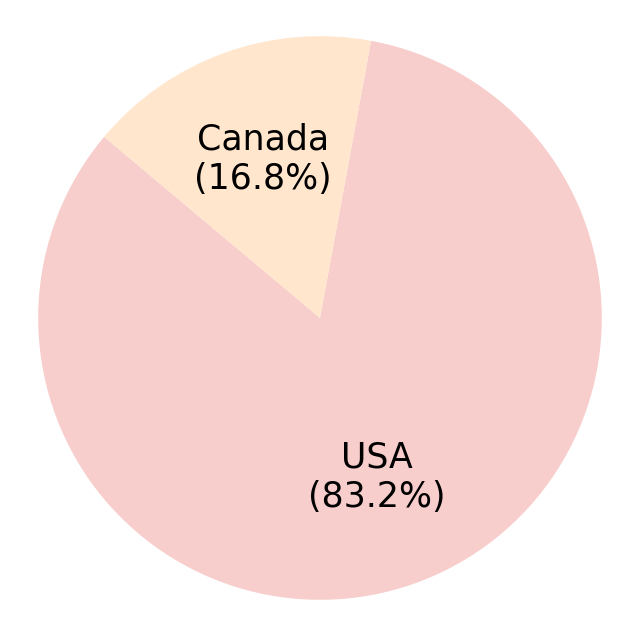

In [0]:
country_counts = df['home_country'].value_counts()
labels = country_counts.index.tolist()
labels = ["Canada" if label == "canada" else "USA" if label == "usa" else label for label in labels]
sizes = country_counts.values.tolist()
total = sum(sizes)
labels_with_pct = [f"{label}\n({size/total:.1%})" for label, size in zip(labels, sizes)]

colors = ["#F8CECC", "#FFE6CC"]  # rosso pastello chiaro, rosso pastello più scuro

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=None, 
    colors=colors[:len(labels)],
    autopct=lambda pct: labels_with_pct.pop(0), 
    startangle=140
)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(25)
plt.axis('equal')
plt.title("")
plt.show()

#Saving Final Tab

In [0]:
df.columns

Index(['user_id', 'nr_sessions', 'date_last_booking_travelled',
       'page_clicks_tot', 'page_clicks_avg', 'flights_taken', 'hotels_stayed',
       'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'flight_taken_discount_nr', 'hotel_stayed_discount_avg',
       'hotel_stayed_discount_nr', 'hotel_and_flight_discount_nr',
       'flight_taken_price_avg', 'hotel_stayed_room_price_per_night_avg',
       'hotel_stayed_nights_avg', 'nr_airlines_taken', 'distance_km_tot',
       'distance_km_avg', 'duration_tot', 'duration_avg', 'birthdate',
       'gender', 'married', 'has_children', 'home_country', 'home_city',
       'home_airport', 'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'age_in_2023', 'age_bin', 'user_spend_tot', 'user_spend_avg',
       'booking_window_days_avg', 'booking_window_days_min',
       'booking_window_days_max', 'family_travelled_trip_nr',
       'non_family_tra

In [0]:
df = df.drop(columns=["RFM_label"]) #Removing first RFM labelling (see notebook about RFM segmentation)
df = df.rename(columns={
    "RFM_label2": "RFM_label",   #Rename RFM_label2 as RFM_label before saving it
    "manual_segments": "BTB_segmentation",  #Rename "manual_segments" as "BTB_segmentation" (Booking and Travel Behaviour Segmentation)
    "manual_segments_HighLevel": "BTB_segmentation_HighLevel" #Rename "manual_segments_HighLevel" as "BTB_segmentation_HighLevel" (Booking and Travel Behaviour Segmentation)
})

In [0]:
%sql
/* to drop the delta lake table, before recreating it*/
DROP TABLE workspace.default.users_FinalTab;

In [0]:
#better to first drop the table, then create it again

# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(df)

# Save as Delta Lake table
spark_df.write.format("delta").mode("overwrite").saveAsTable("users_FinalTab") #SAVED AS "users_FinalTab.csv"